# Steps
1. Train DECODE network -> trained model
2. Localise 3D data using notebook and re-map columns for picasso compatibility -> out.hdf5
3. Undrift using picasso -> out_undrift.hdf5
4. Flip data using cell below -> out_undrift_flipped.hdf5
5. Pick nuclear pores in Picasso to match vision transformer dataset out_undrift_flipped_picked.hdf5
6. Run group matching cells below locs3d_undrift.hdf5
7. Run render_nup.py

In [ ]:
# 4. Flip data

import pandas as pd
import seaborn as sns
from sklearn.metrics import euclidean_distances
df = pd.read_hdf('/home/miguel/Projects/smlm_z/publication/comparisons/decode_2/notebooks/out_undrift.hdf5', key='locs')

swap_cols = [
    ('x', 'y'),
    ('lpx', 'lpy'),
    ('sx', 'sy')
]
for c1, c2 in swap_cols:
    df[[c1, c2]] = df[[c2, c1]]


print(list(df))
import h5py
if 'index' in list(df):
    del df['index']
locs_path = '/home/miguel/Projects/smlm_z/publication/comparisons/decode_2/notebooks/out_undrift_flipped.hdf5'
with h5py.File(locs_path, "w") as locs_file:
    locs_file.create_dataset("locs", data=df.to_records())

In [ ]:
# 5. Pick nuclear pores to match vision transformer dataset

/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'x [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'y [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'z [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this obje

(76274, 18)


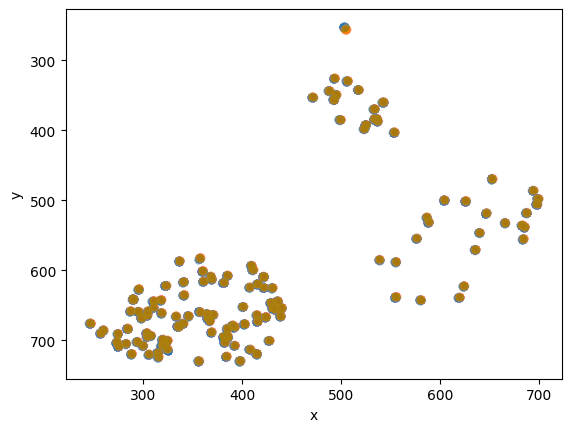

In [54]:
# 6. Run group matching cells below
import pandas as pd
import seaborn as sns
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
df_new = pd.read_hdf('/home/miguel/Projects/smlm_z/publication/comparisons/decode_2/notebooks/out_undrift_flipped_picked.hdf5', key='locs')
df_orig = pd.read_hdf('/home/miguel/Projects/data/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome_locs_undrifted_picked_4.hdf5', key='locs')
print(df_new.shape)


    
sns.scatterplot(data=df_new, x='x', y='y', alpha=0.01)
sns.scatterplot(data=df_orig, x='x', y='y', alpha=0.01)
plt.gca().invert_yaxis()

In [55]:
import numpy as np
from tqdm import trange
import tensorflow as tf

def _euclidean_distances(coords1, coords2, reduce_min=None):
    """
    Compute the Euclidean distances between two sets of 2D coordinates.

    Args:
        coords1 (tf.Tensor): A tensor of shape (N, 2) containing N 2D coordinates.
        coords2 (tf.Tensor): A tensor of shape (M, 2) containing M 2D coordinates.

    Returns:
        tf.Tensor: A tensor of shape (N, M) containing the Euclidean distances
                   between each pair of coordinates from coords1 and coords2.
    """
    # Ensure inputs are TensorFlow tensors
    coords1 = tf.convert_to_tensor(coords1, dtype=tf.float32)
    coords2 = tf.convert_to_tensor(coords2, dtype=tf.float32)

    t1 = tf.reshape(coords1, (1, *coords1.shape))
    t2 = tf.reshape(coords2, (coords2.shape[0],1,coords2.shape[1]))
    result = tf.norm(t1-t2, ord='euclidean', axis=2,)
    if reduce_min is not None:
        result = tf.math.reduce_min(result, axis=reduce_min, keepdims=False)
    res = result.numpy()
    del result
    return res
    
def batched_euclidean_distance(coords1, coords2, batch_size, reduce_min=None):
    if reduce_min:
        min_dists = np.zeros((coords1.shape[0],))
    else:
        min_dists = np.zeros((coords2.shape[0], coords1.shape[0]))
    from tqdm import trange
    for i in trange(0, coords1.shape[0]-1, batch_size):
        start, end = i, i+batch_size
        _coords1 = coords1[start:end]
        _min_dists = _euclidean_distances(_coords1, coords2, reduce_min)
        min_dists[start:end] = _min_dists
    return min_dists

df_new_groups = df_new.groupby('group').mean()
df_orig_groups = df_orig.groupby('group').mean()

df_new_groups.reset_index(inplace=True, drop=False)
df_orig_groups.reset_index(inplace=True, drop=False)

xy_new = df_new_groups[['x', 'y']].to_numpy()
xy_orig = df_orig_groups[['x', 'y']].to_numpy()

# # Adjust batch size to fit in GPU memory
BATCH_SIZE = 2**14

# print(xy_new.shape)
# print(BATCH_SIZE)

min_dists = batched_euclidean_distance(xy_new, xy_orig, BATCH_SIZE)

print(min_dists.min(), min_dists.mean(), min_dists.max())


100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.70it/s]

0.4823673367500305 193.31690924473915 513.5428466796875


In [56]:
import matplotlib.pyplot as plt

mapped_groups = min_dists.argmin(axis=0)

df_new['group'] = [mapped_groups[x] for x in df_new['group']]
df_new['clusterID'] = df_new['group']

import h5py
if 'index' in list(df_new):
    del df_new['index']
locs_path = '/home/miguel/Projects/smlm_z/publication/comparisons/decode_2/notebooks/locs_3d_undrift.hdf5'
with h5py.File(locs_path, "w") as locs_file:
    locs_file.create_dataset("locs", data=df_new.to_records())

115
nup_0_gaussian.png


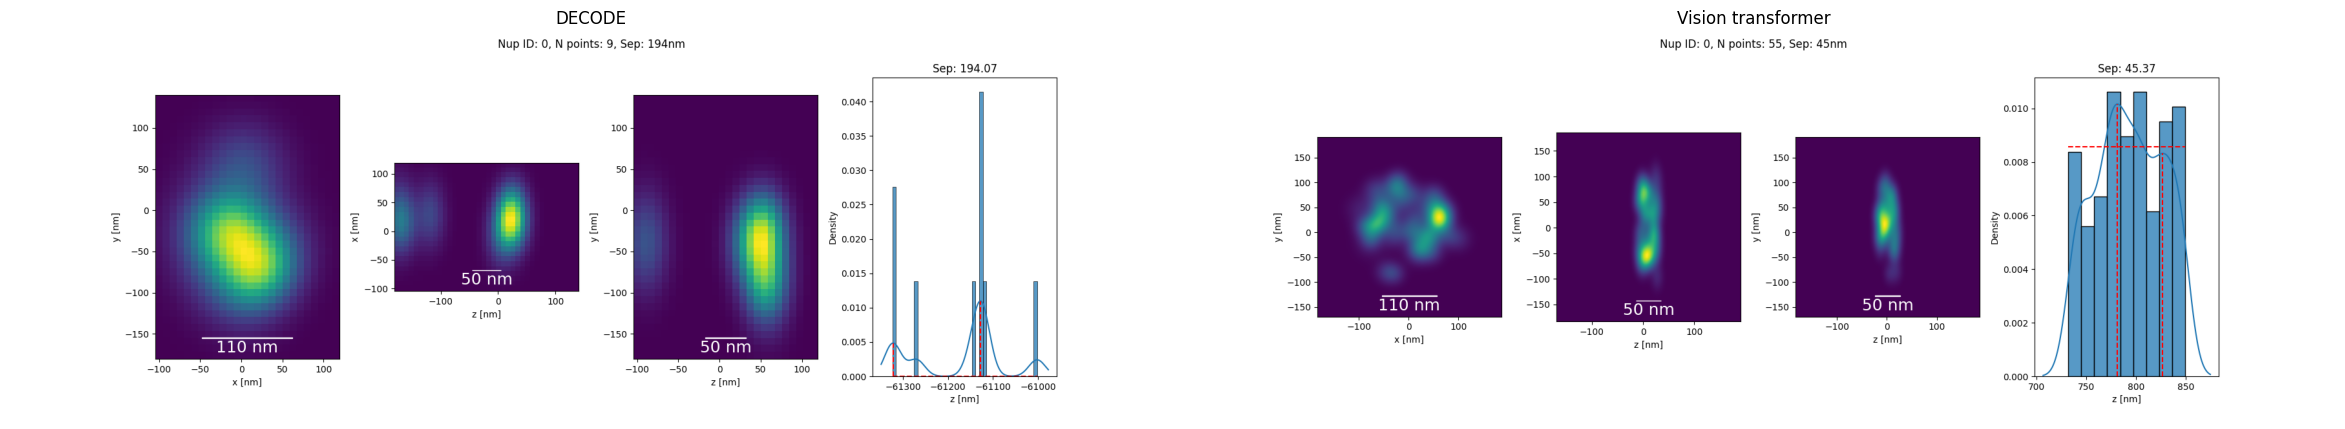

nup_4_gaussian.png


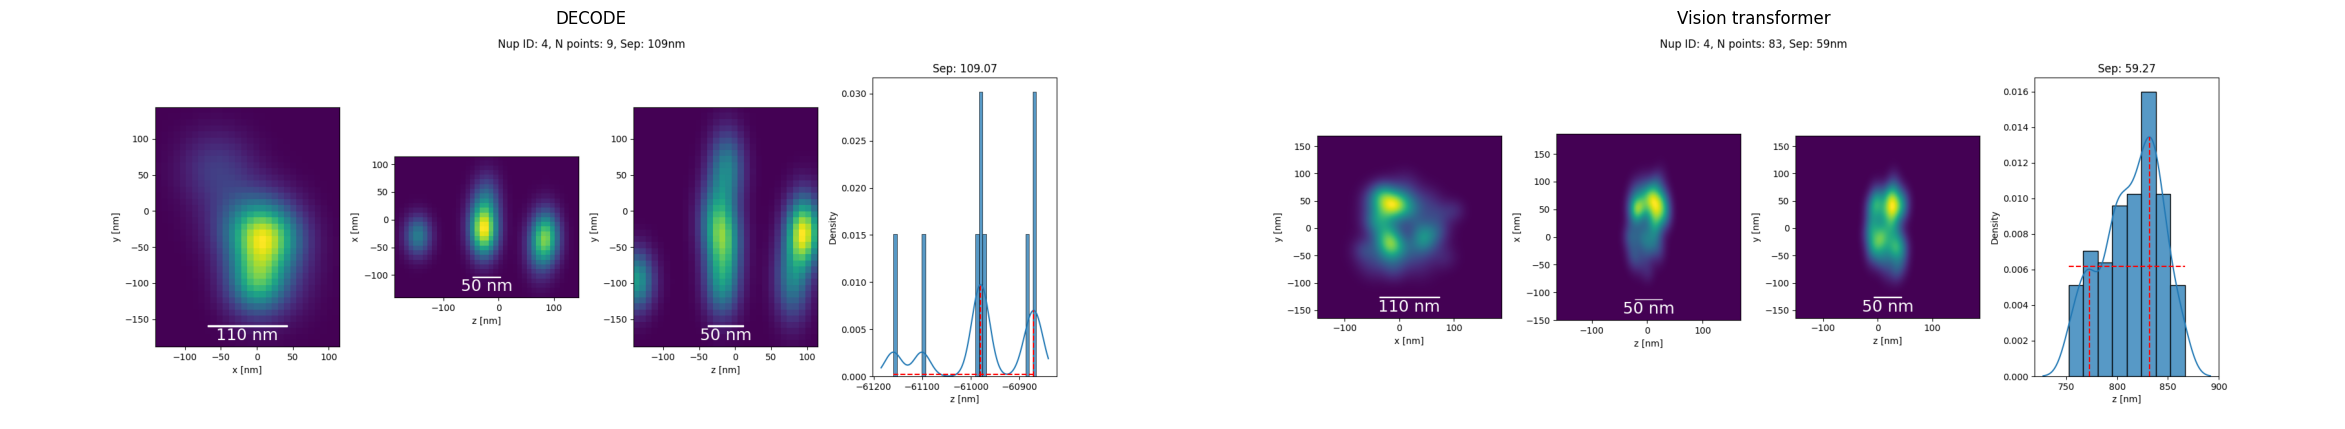

nup_6_gaussian.png


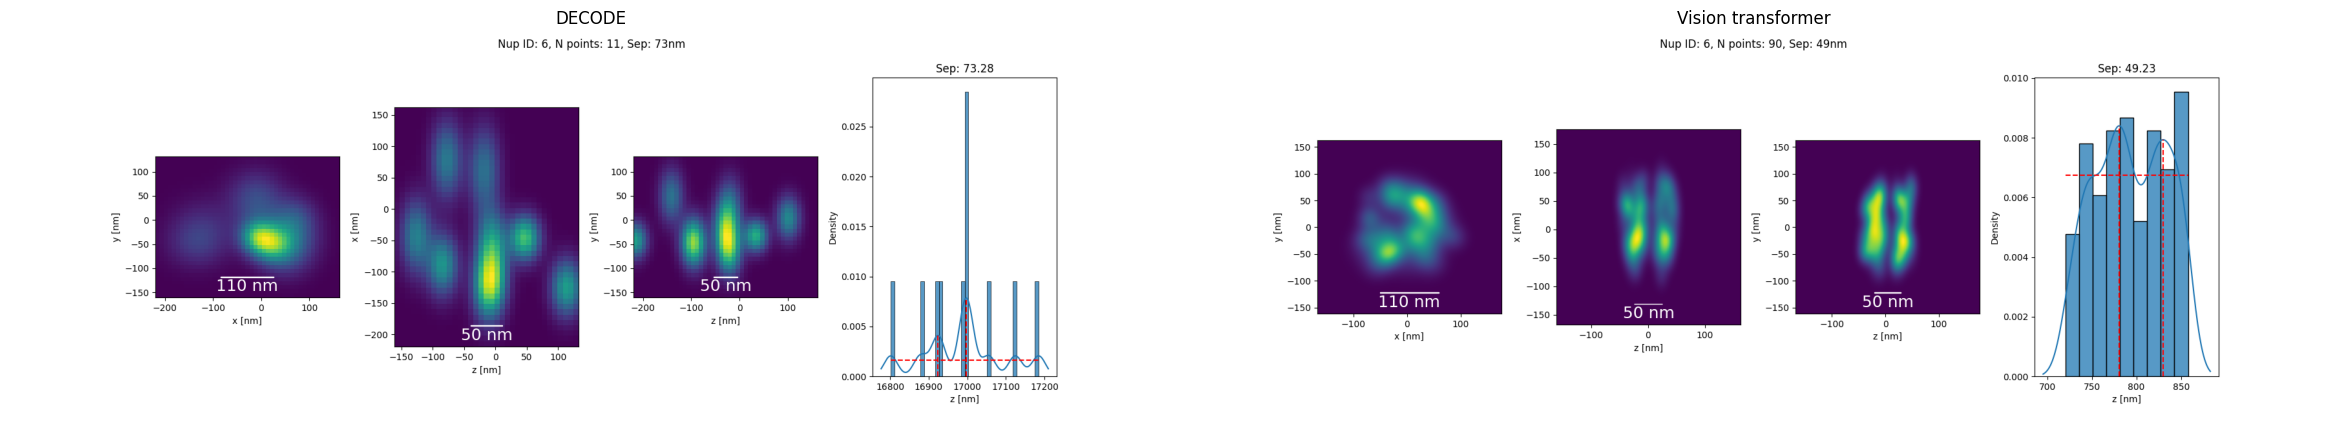

nup_18_gaussian.png


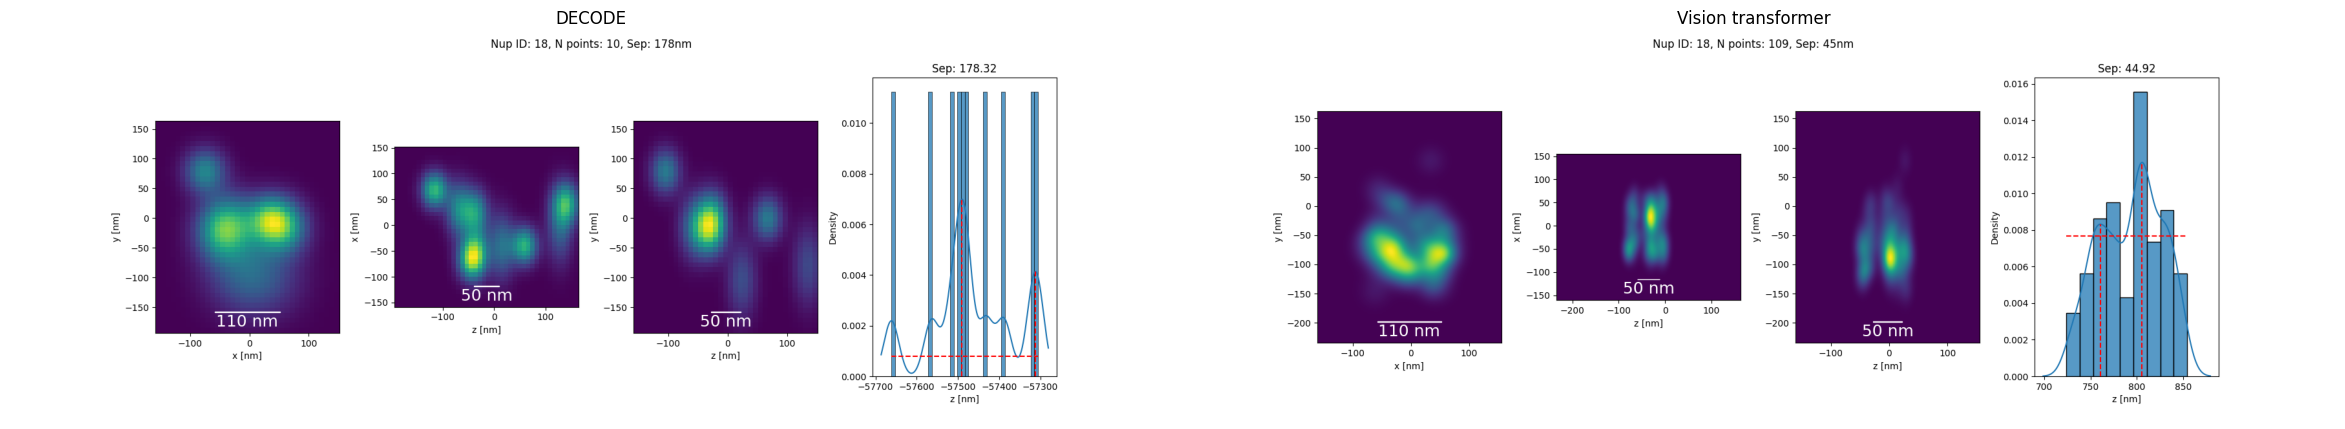

nup_19_gaussian.png


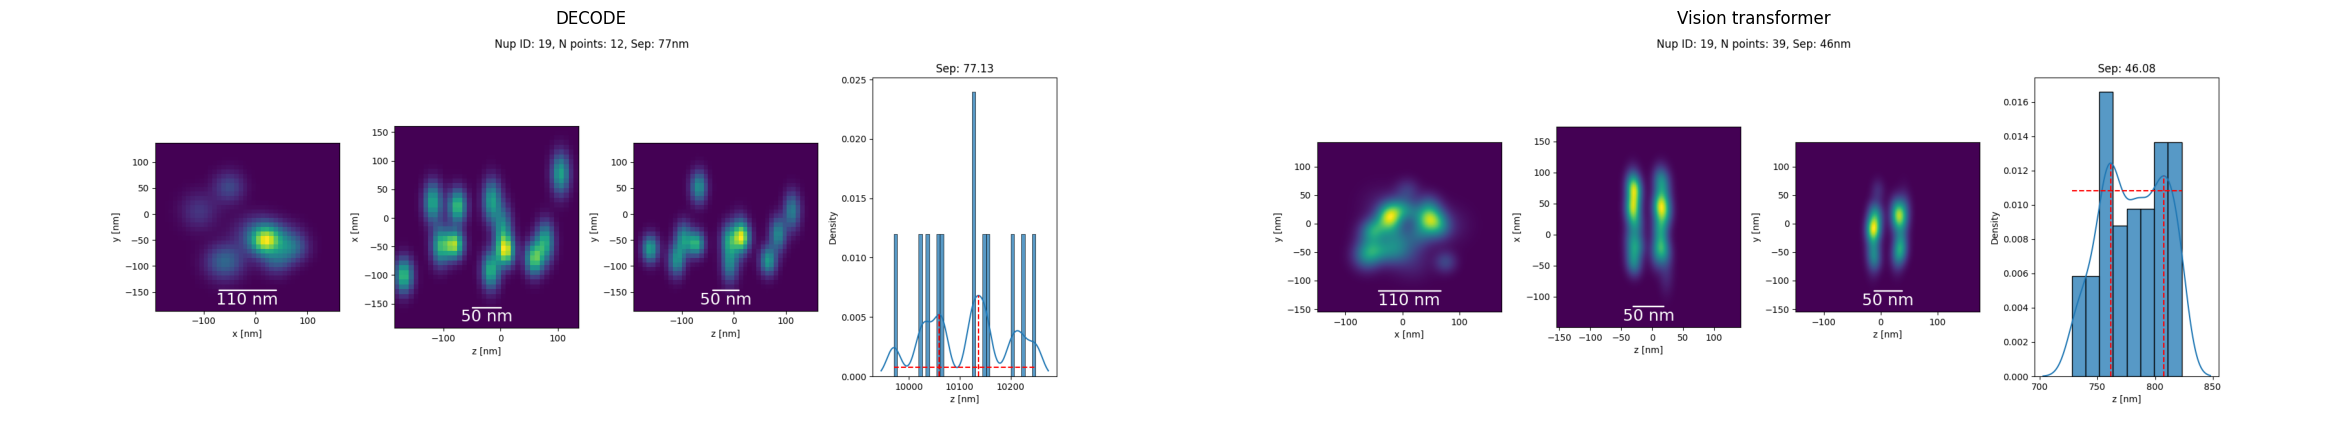

nup_20_gaussian.png


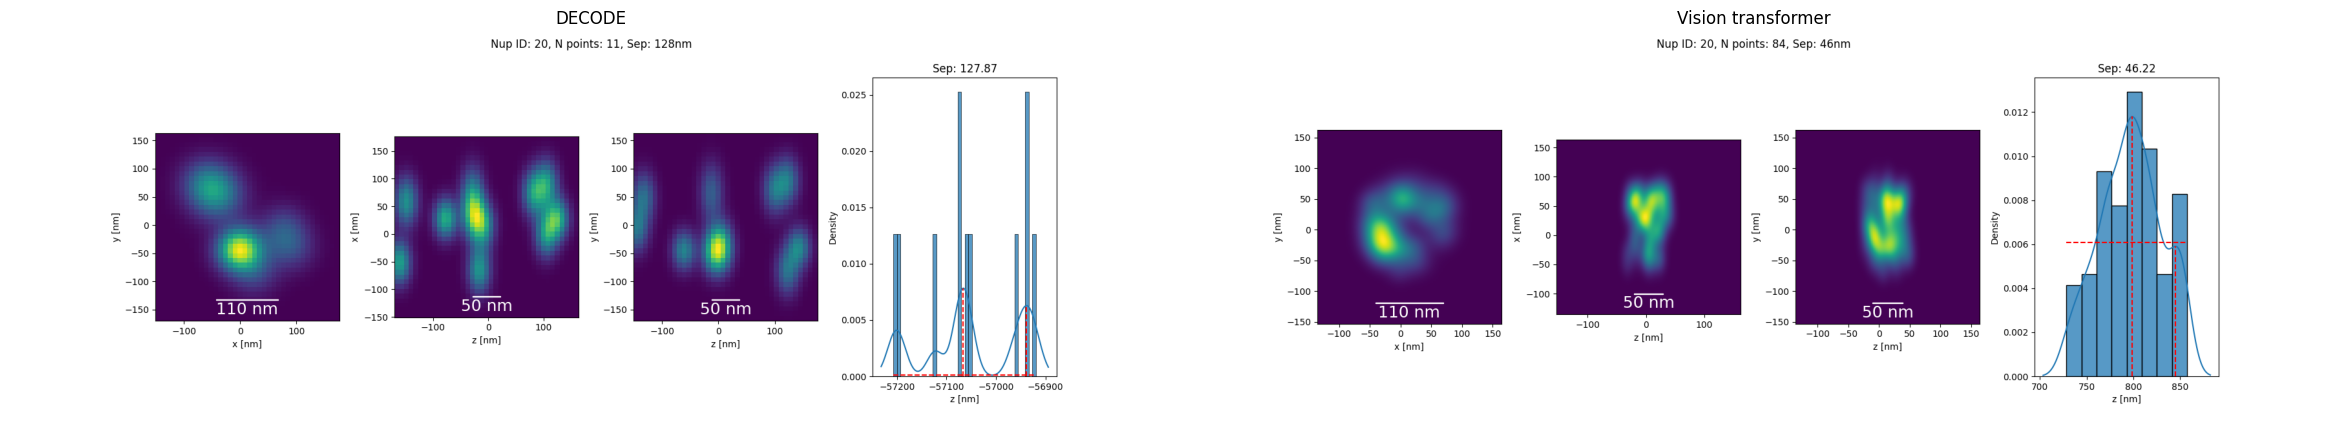

nup_21_gaussian.png


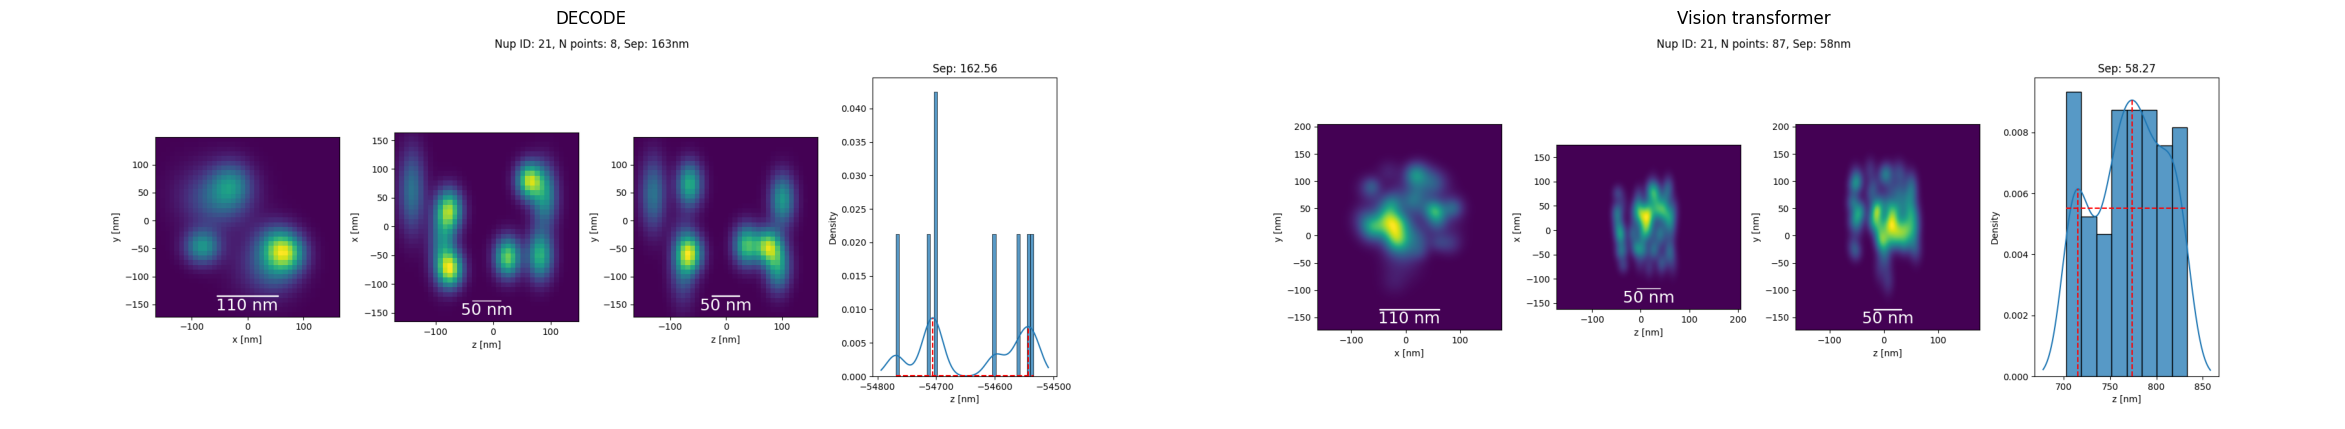

nup_22_gaussian.png


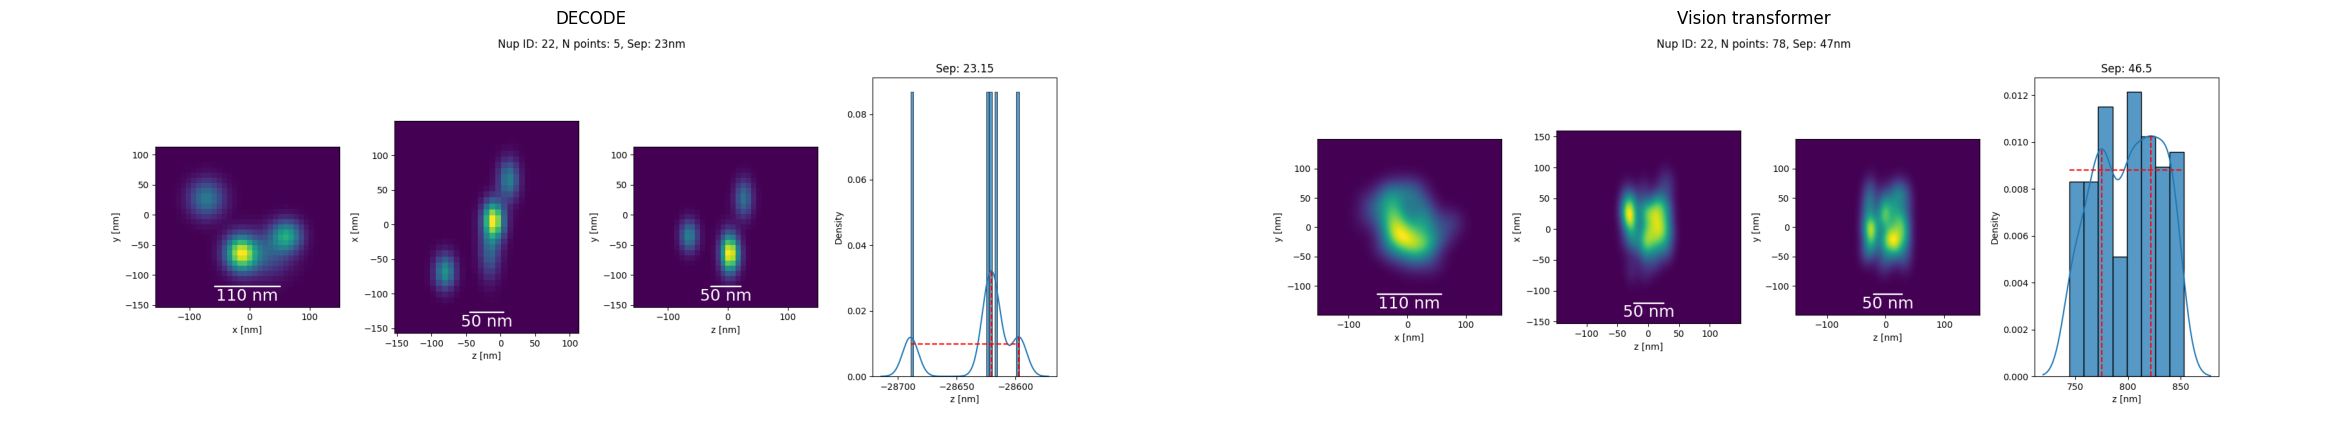

nup_25_gaussian.png


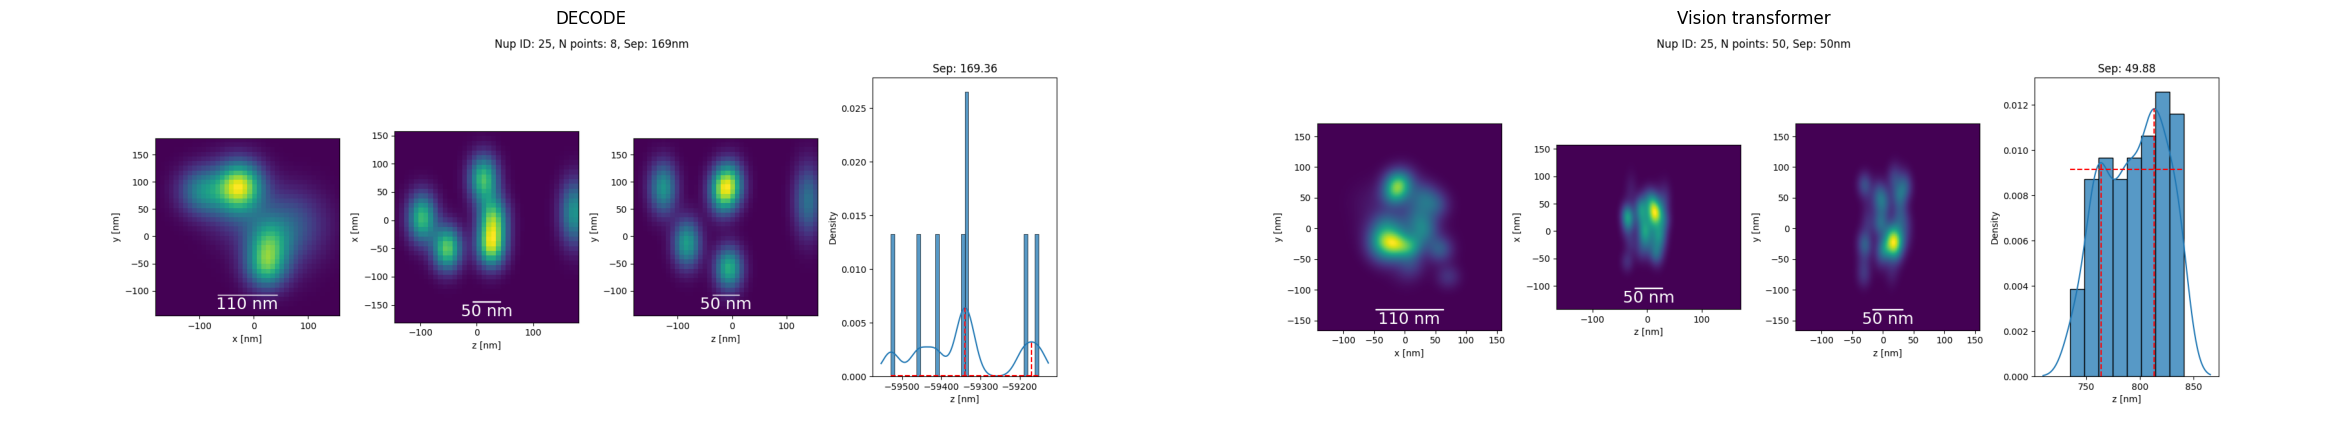

nup_26_gaussian.png


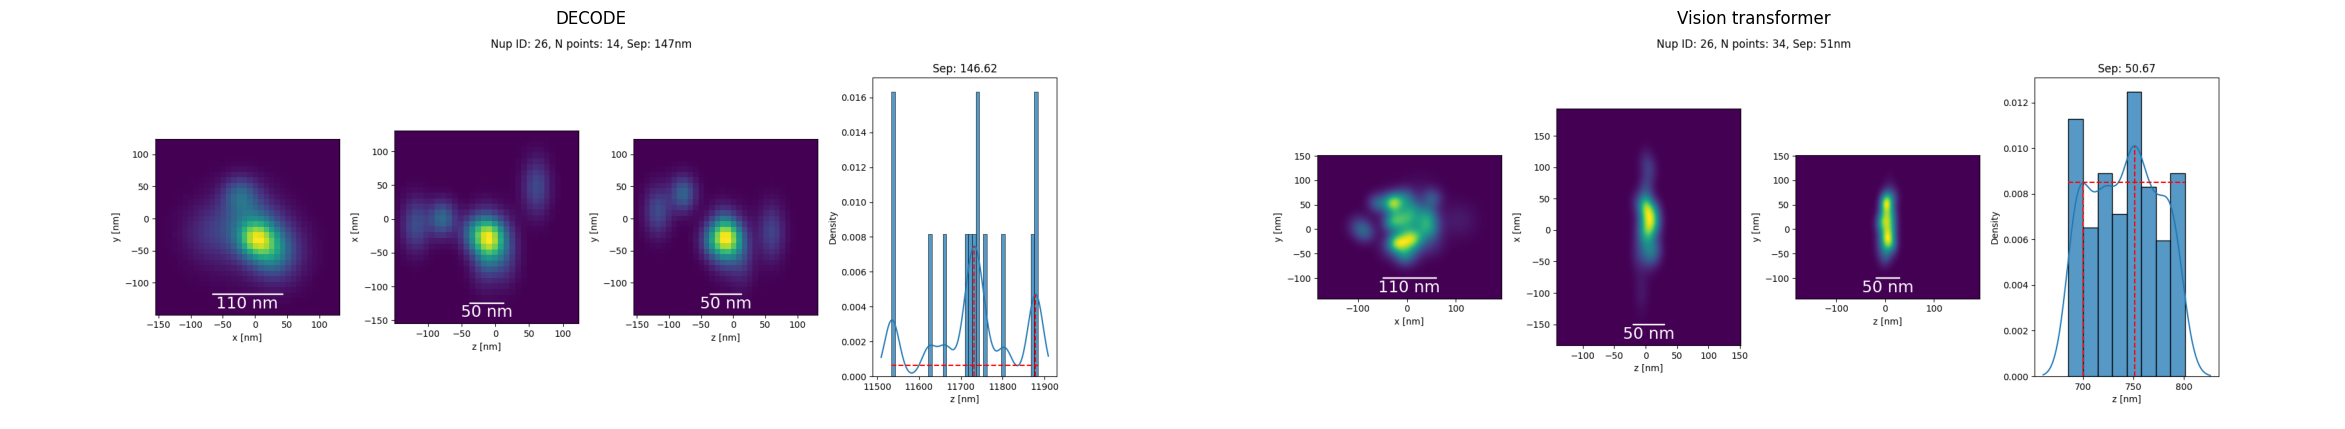

nup_30_gaussian.png


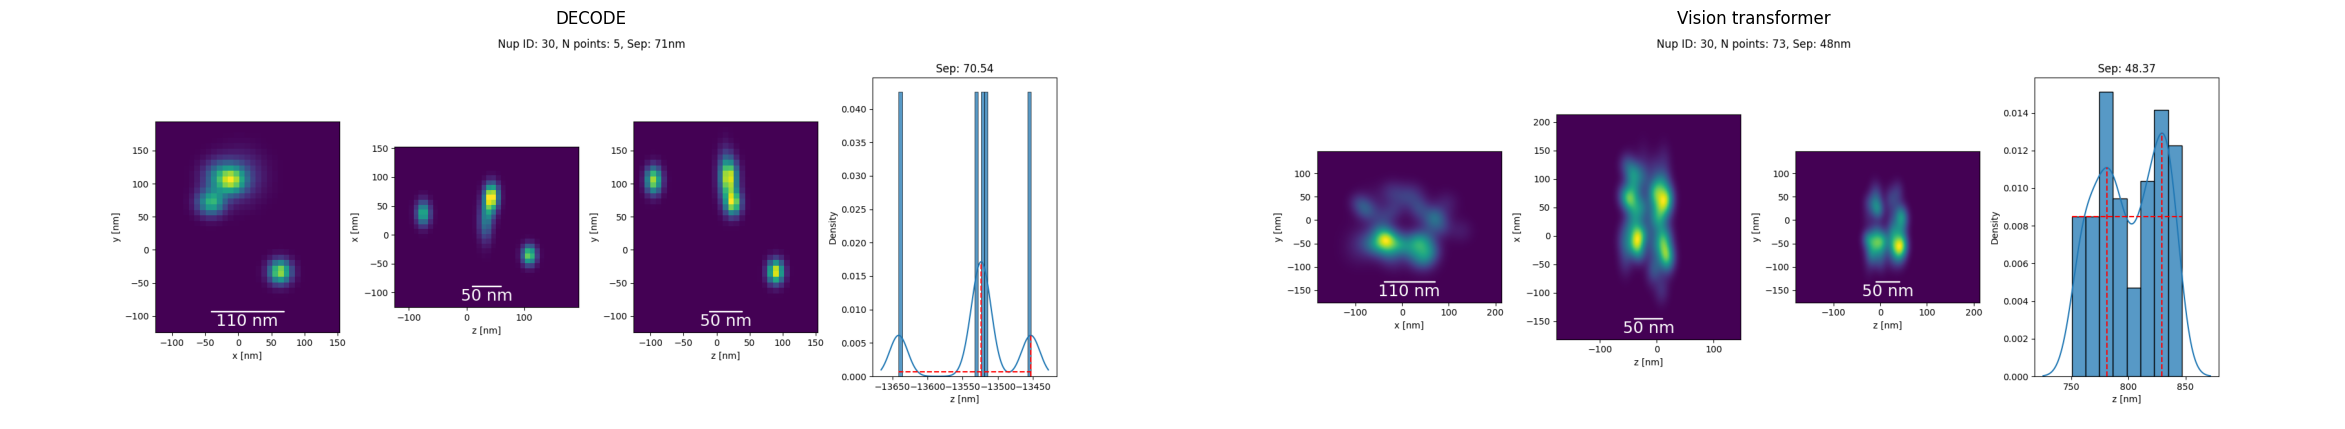

nup_32_gaussian.png


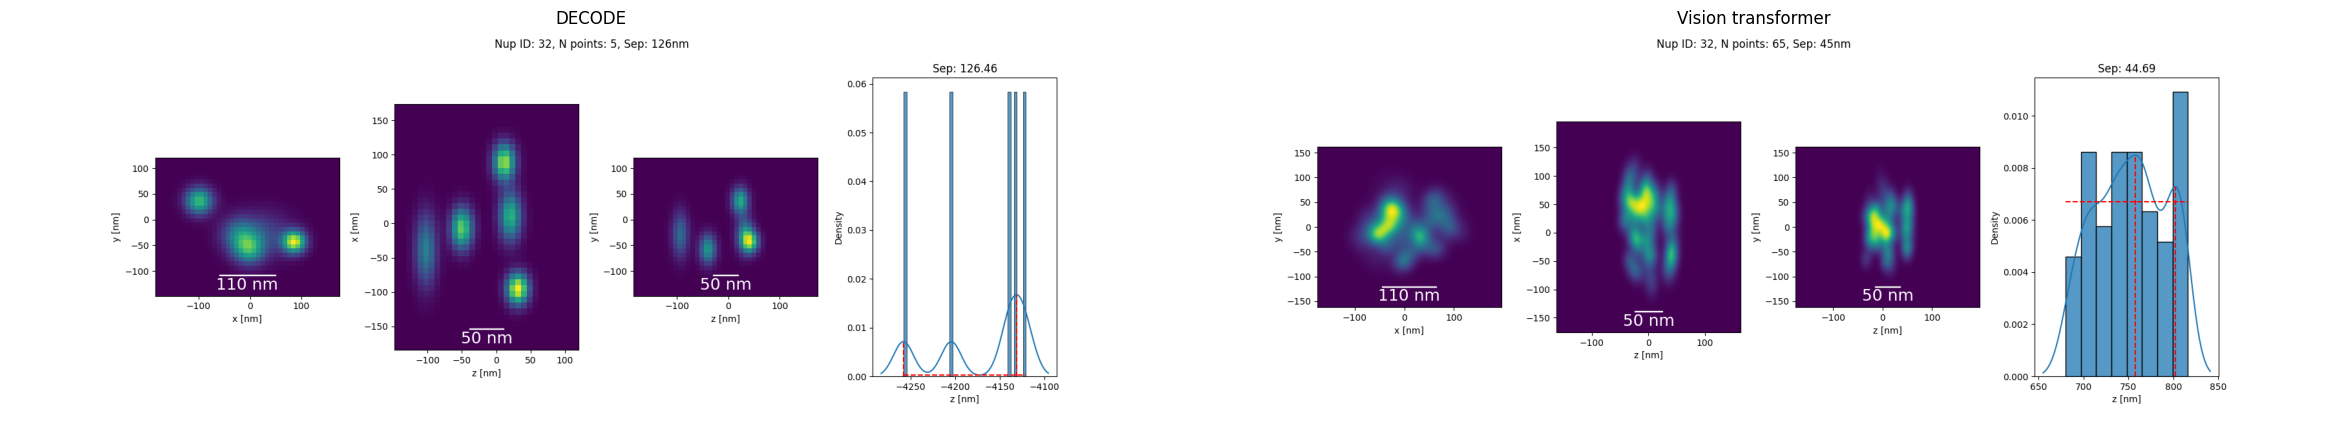

nup_33_gaussian.png


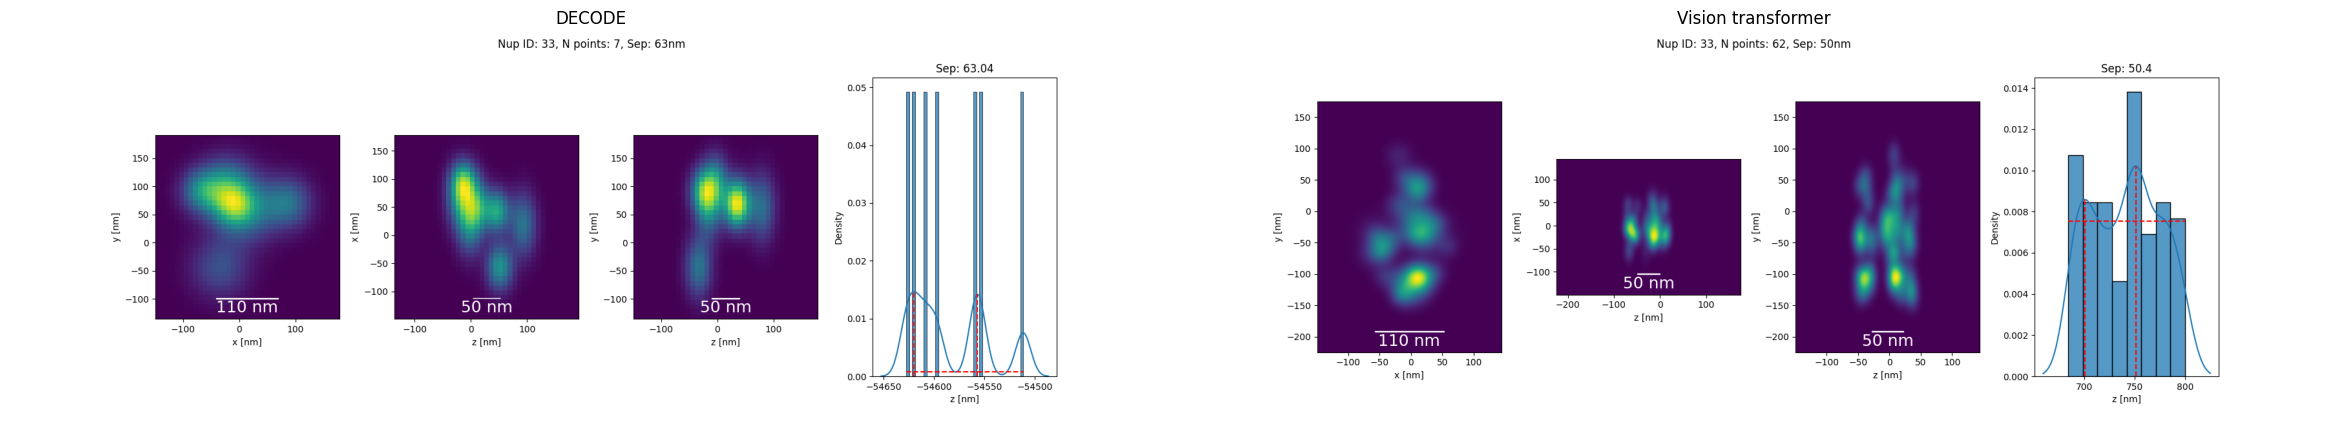

nup_38_gaussian.png


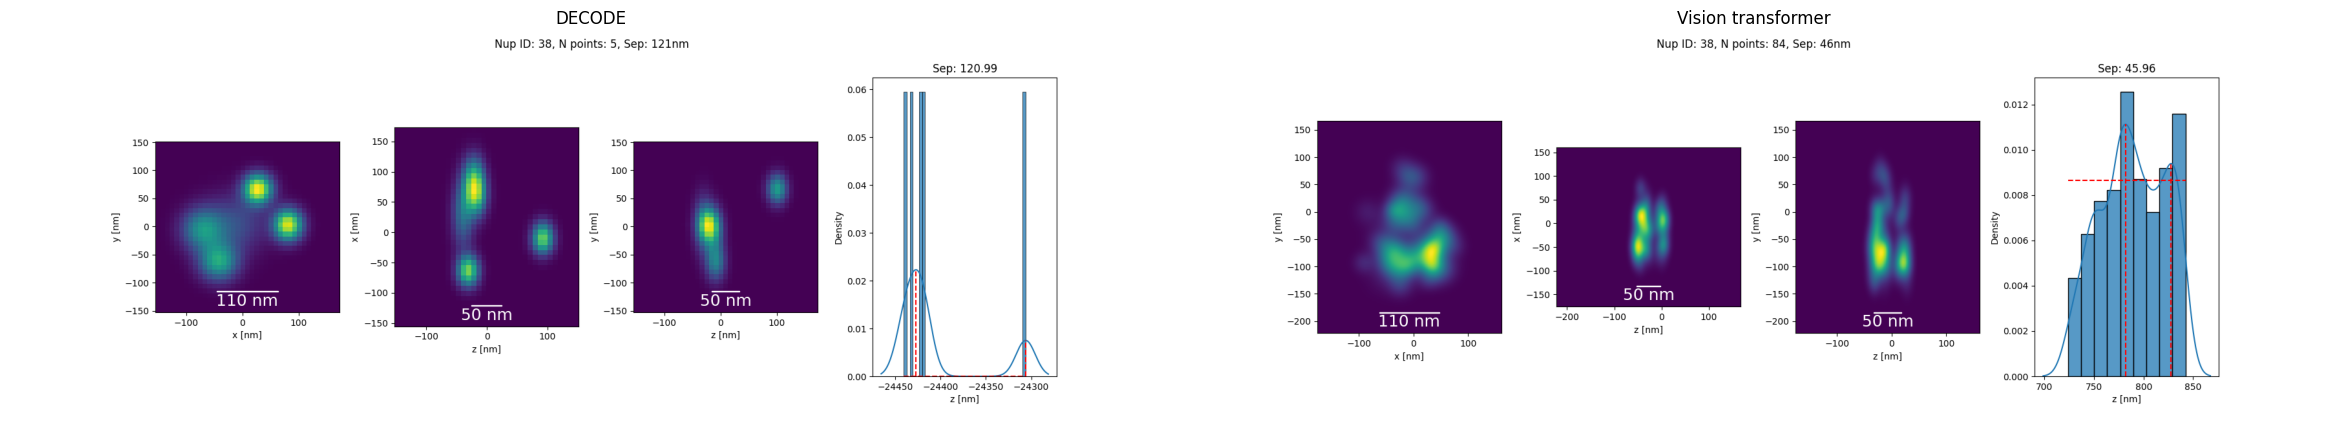

nup_41_gaussian.png


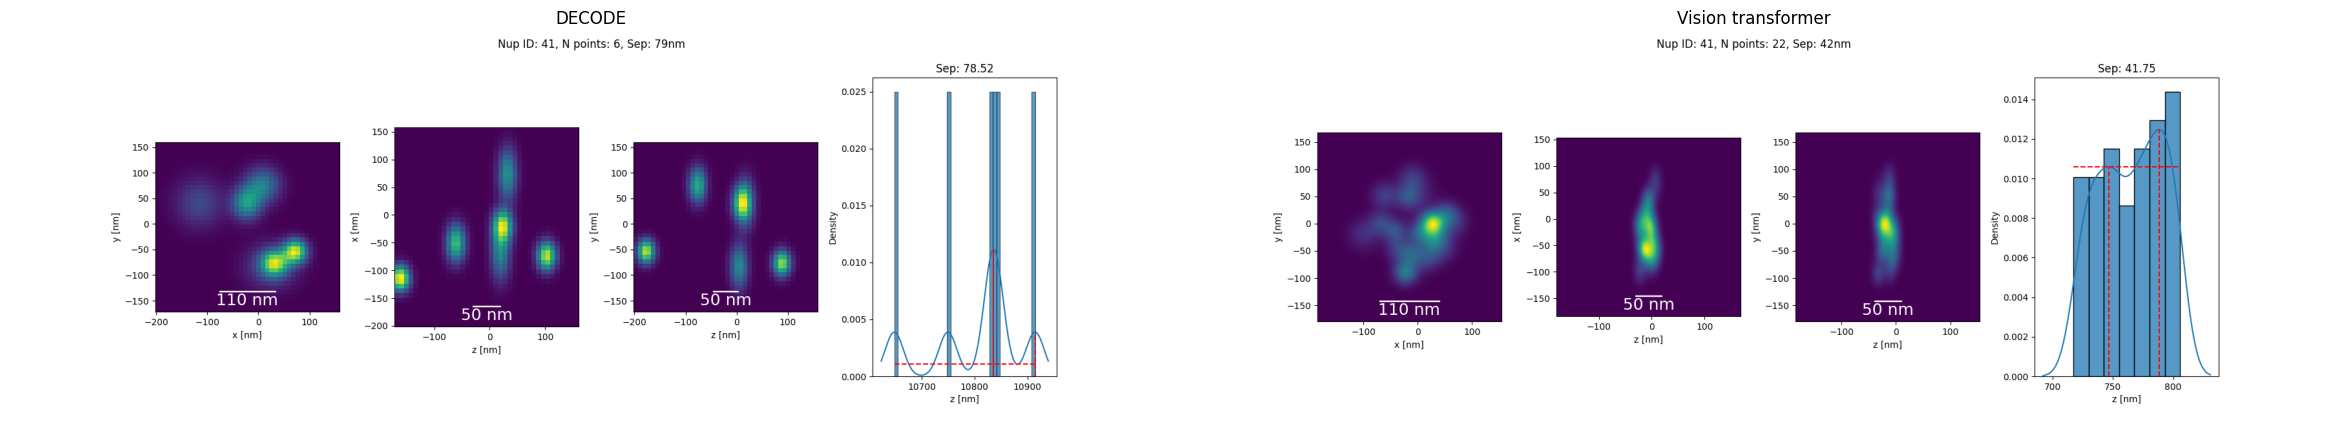

nup_42_gaussian.png


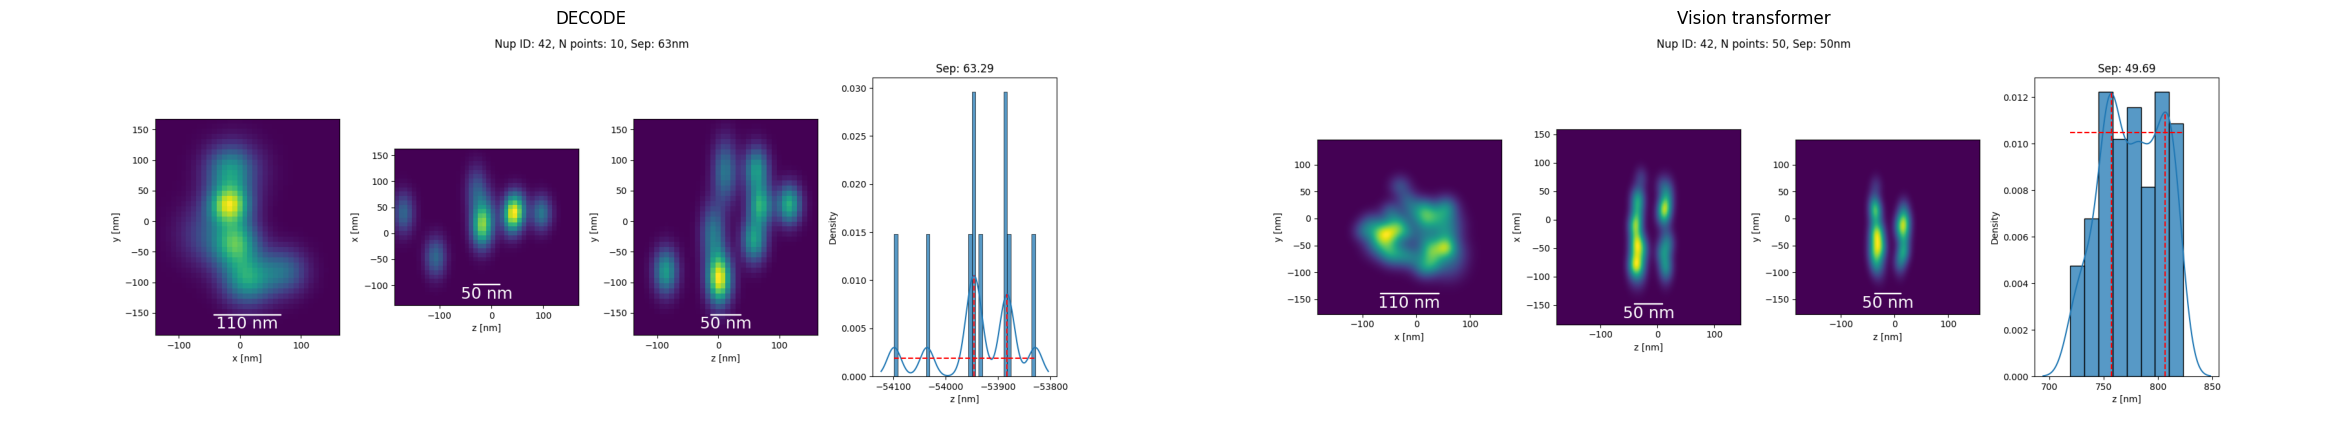

nup_43_gaussian.png


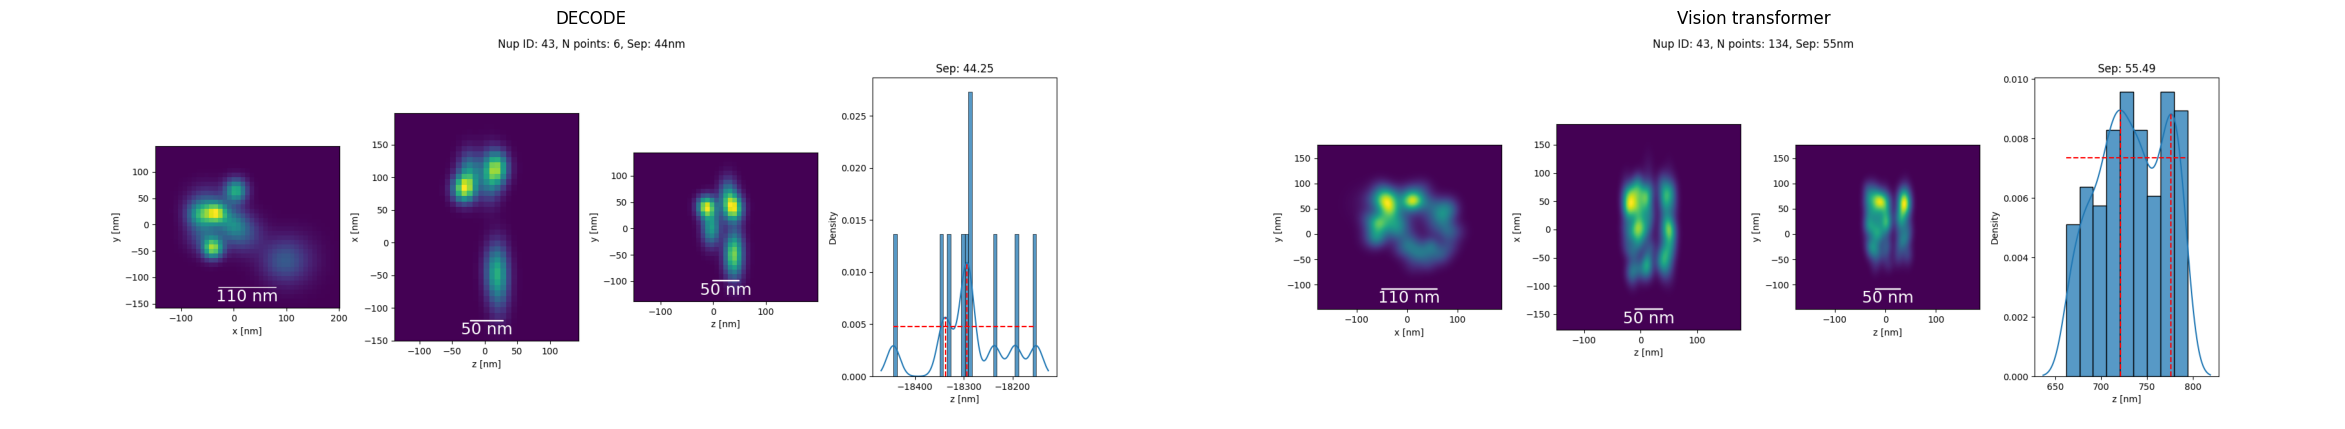

nup_47_gaussian.png


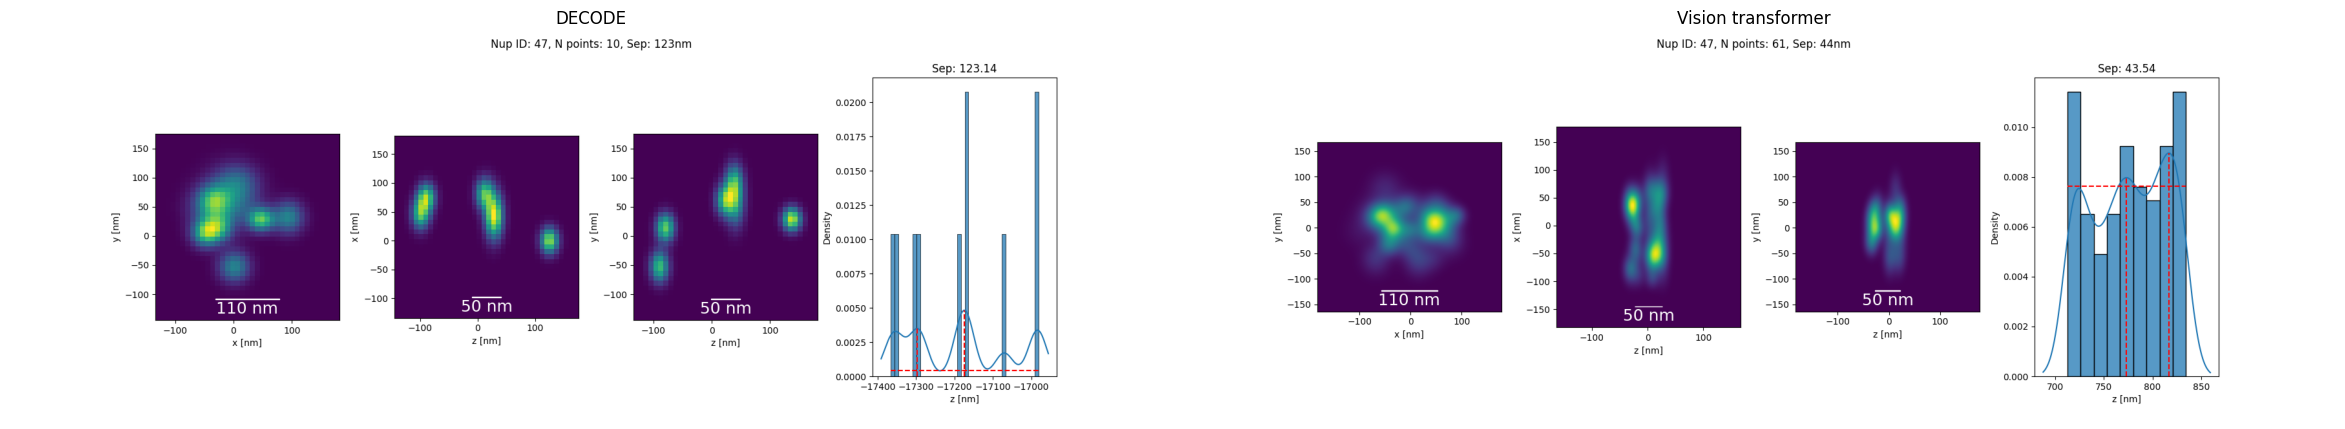

nup_48_gaussian.png


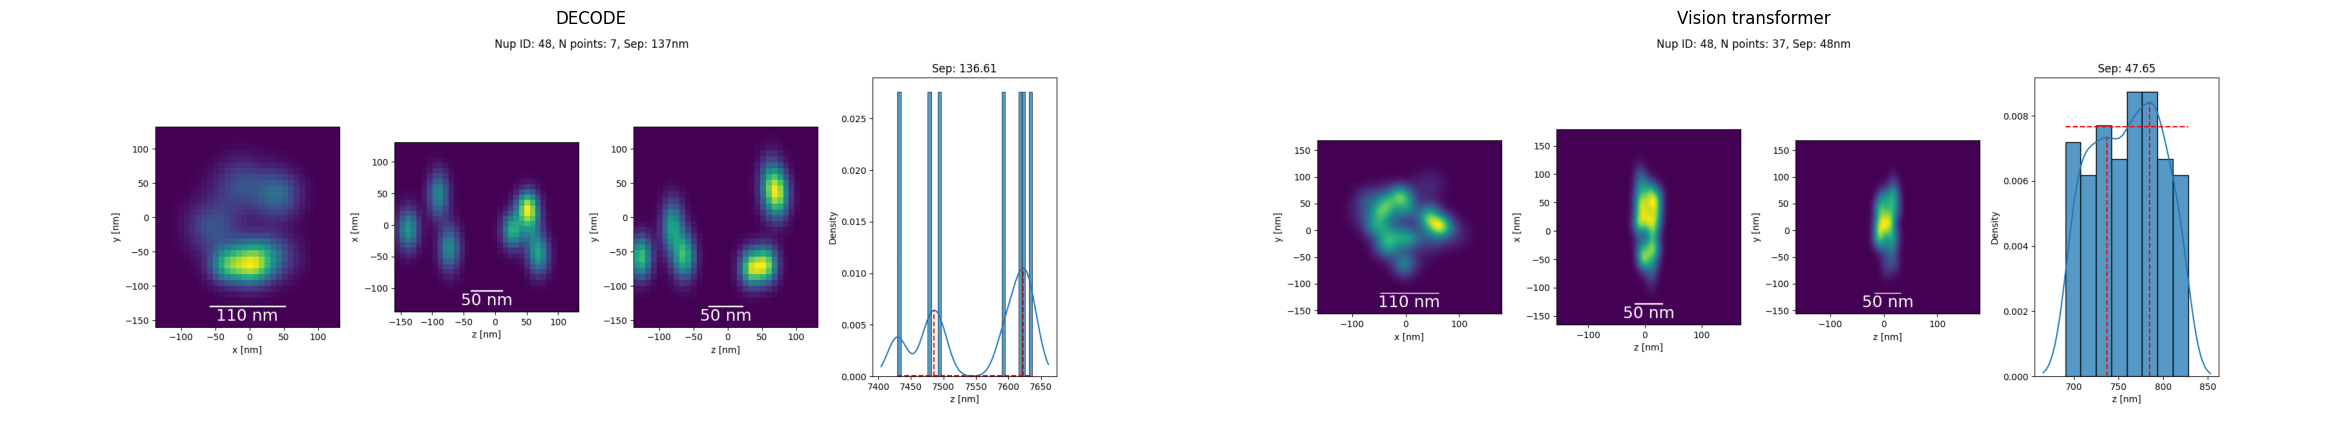

nup_49_gaussian.png


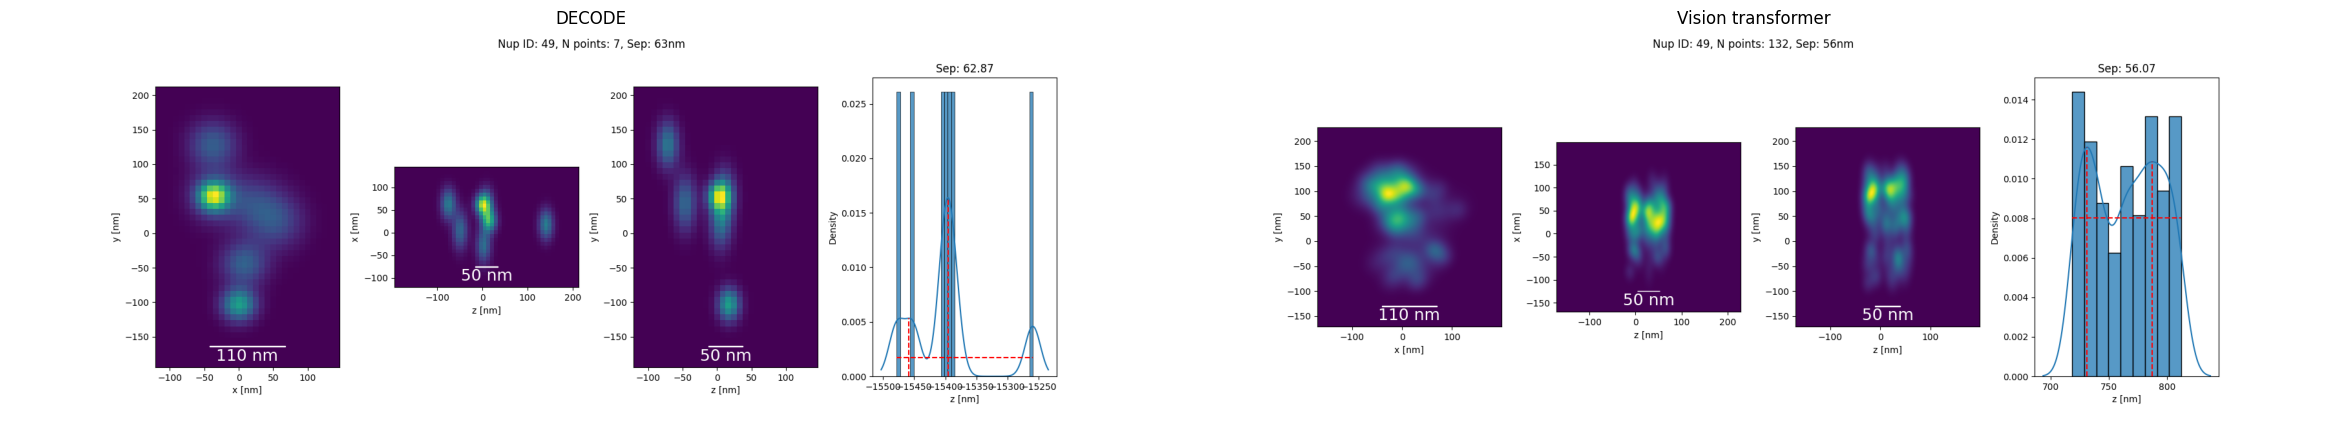

nup_53_gaussian.png


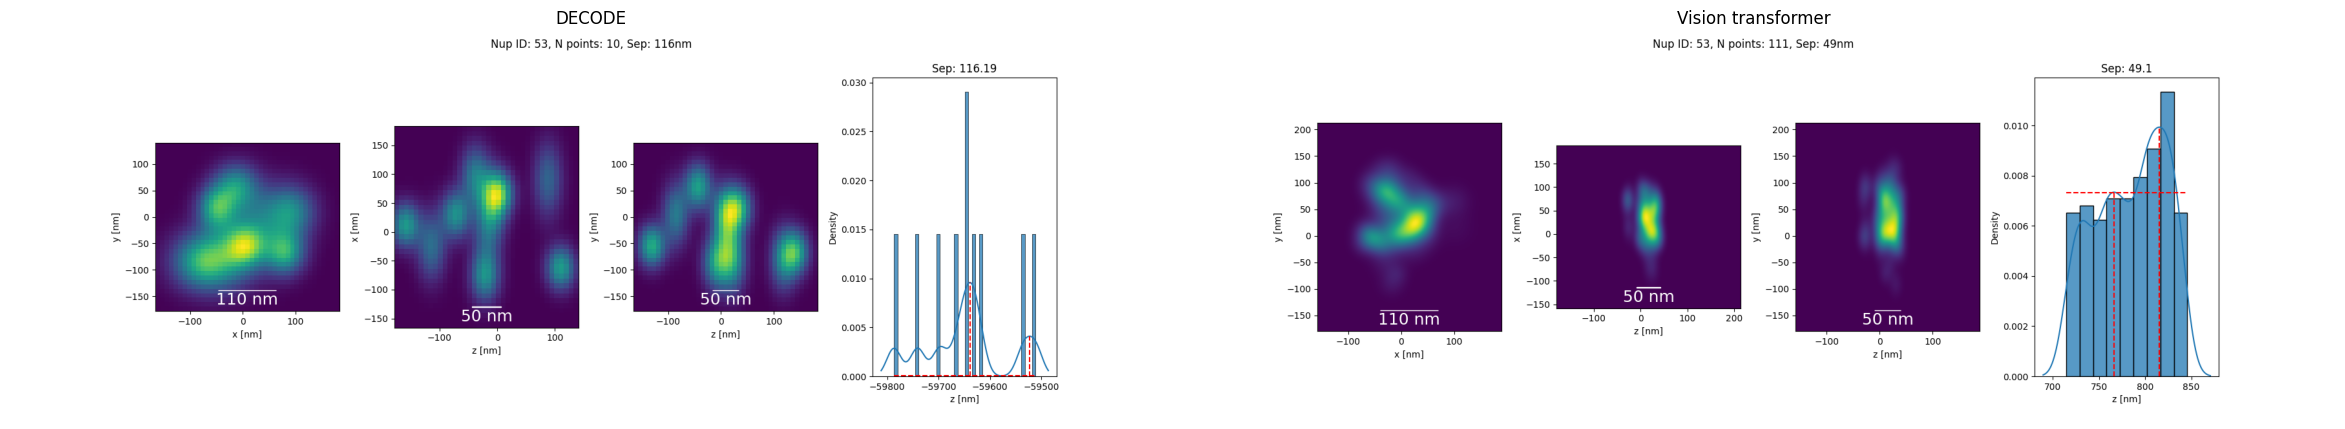

nup_55_gaussian.png


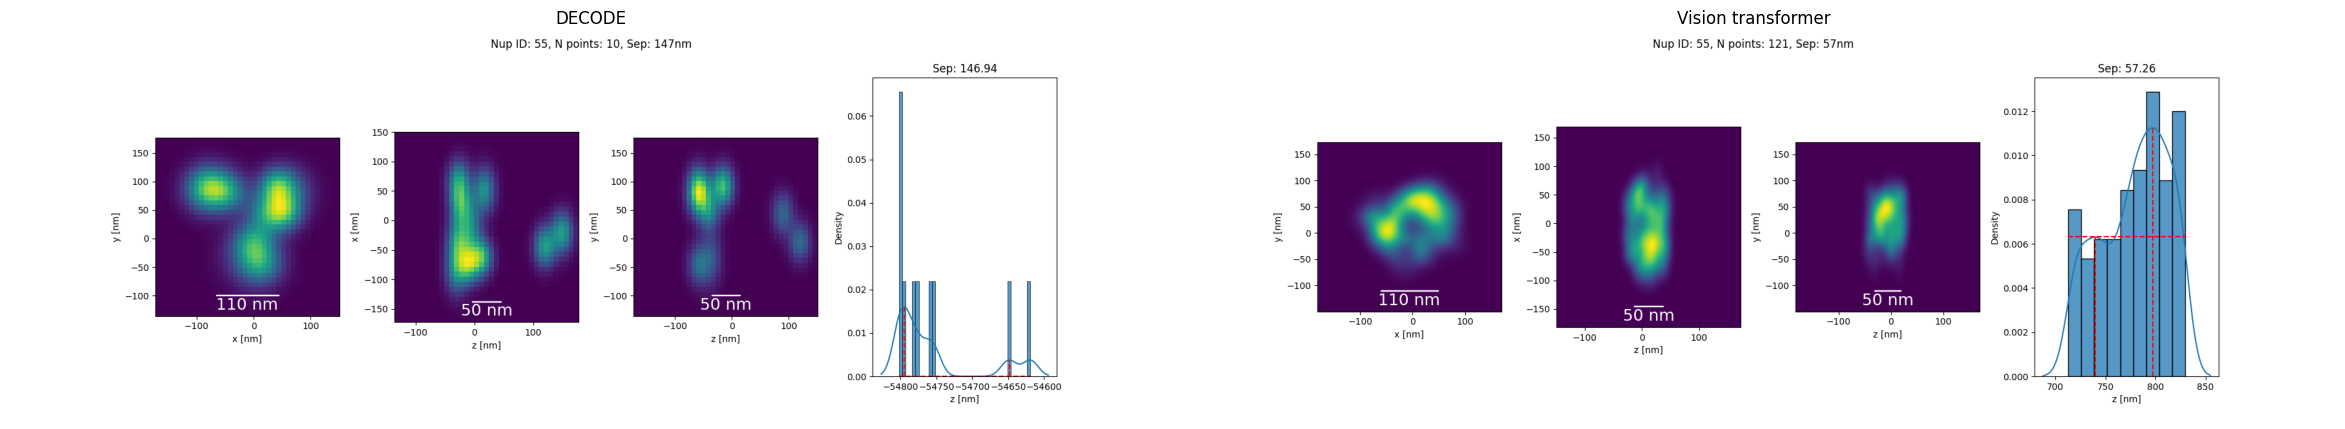

nup_58_gaussian.png


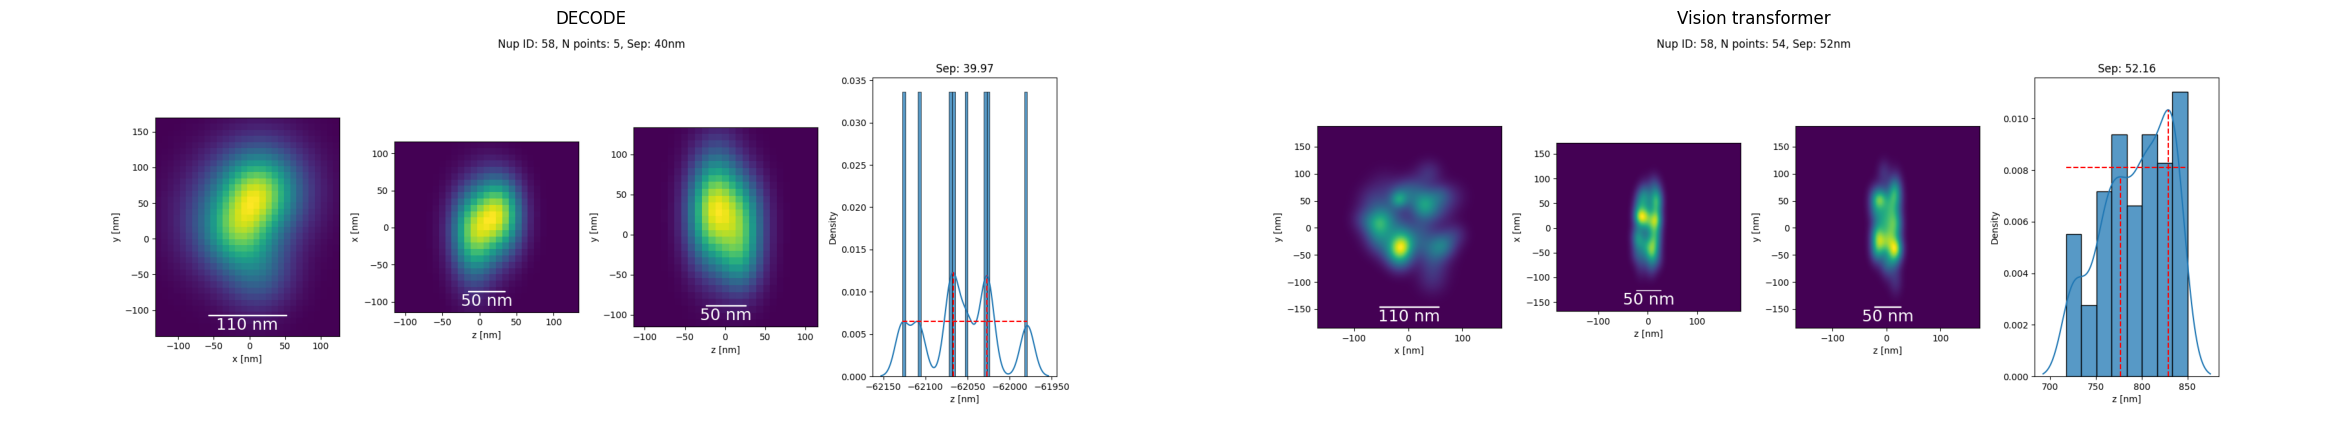

nup_60_gaussian.png


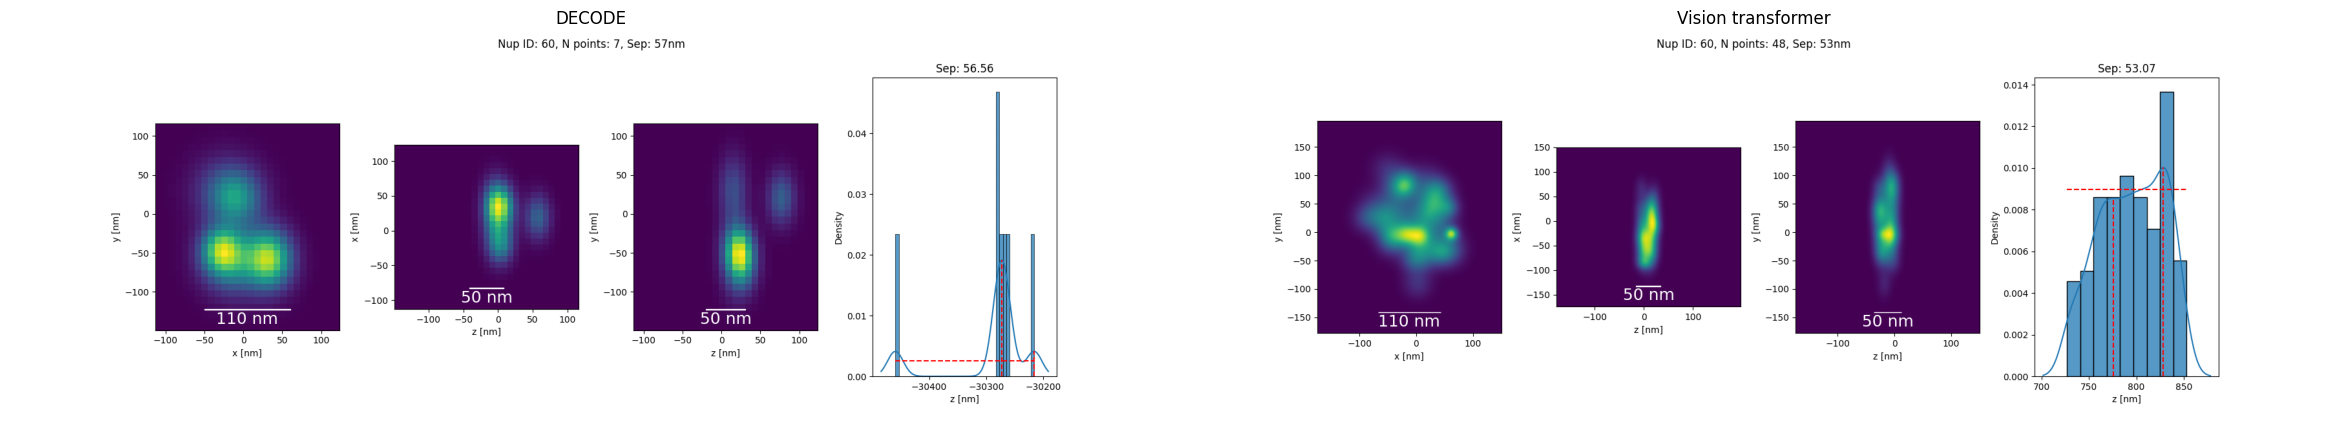

nup_72_gaussian.png


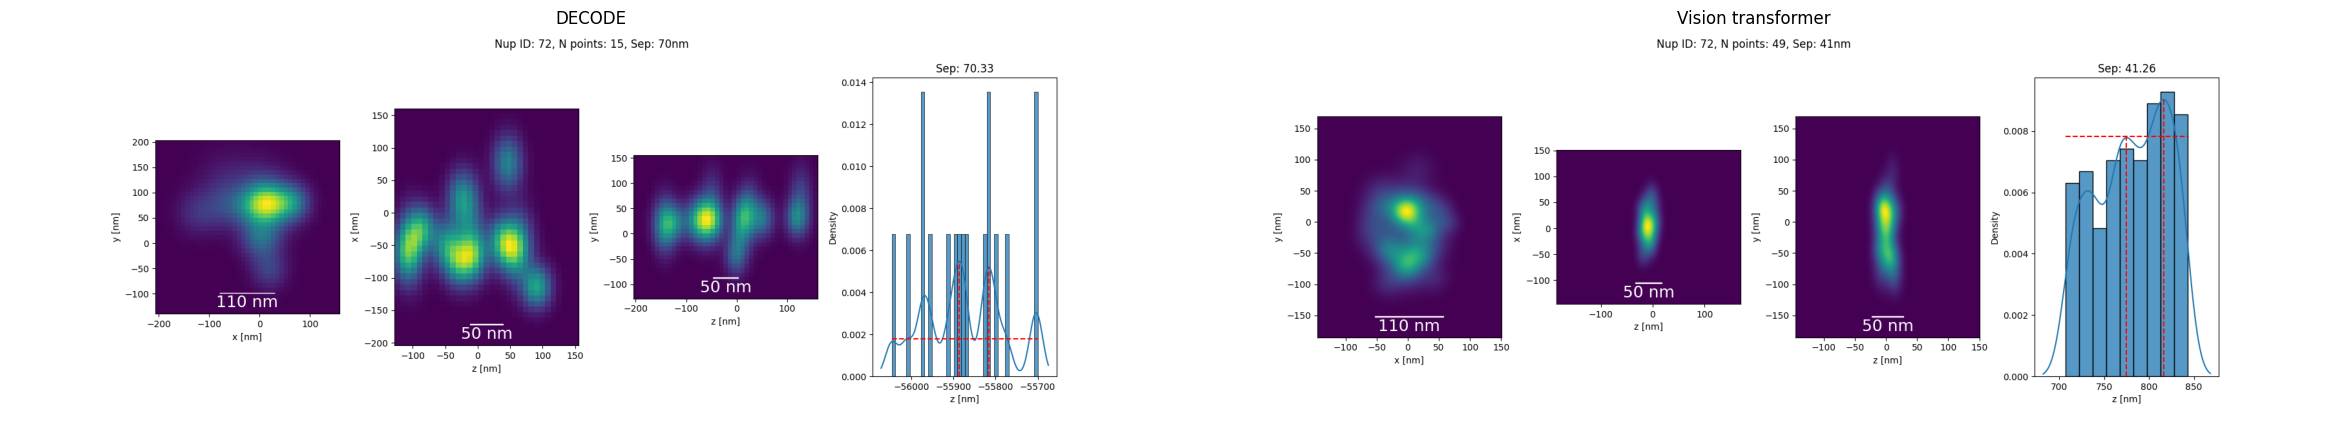

nup_74_gaussian.png


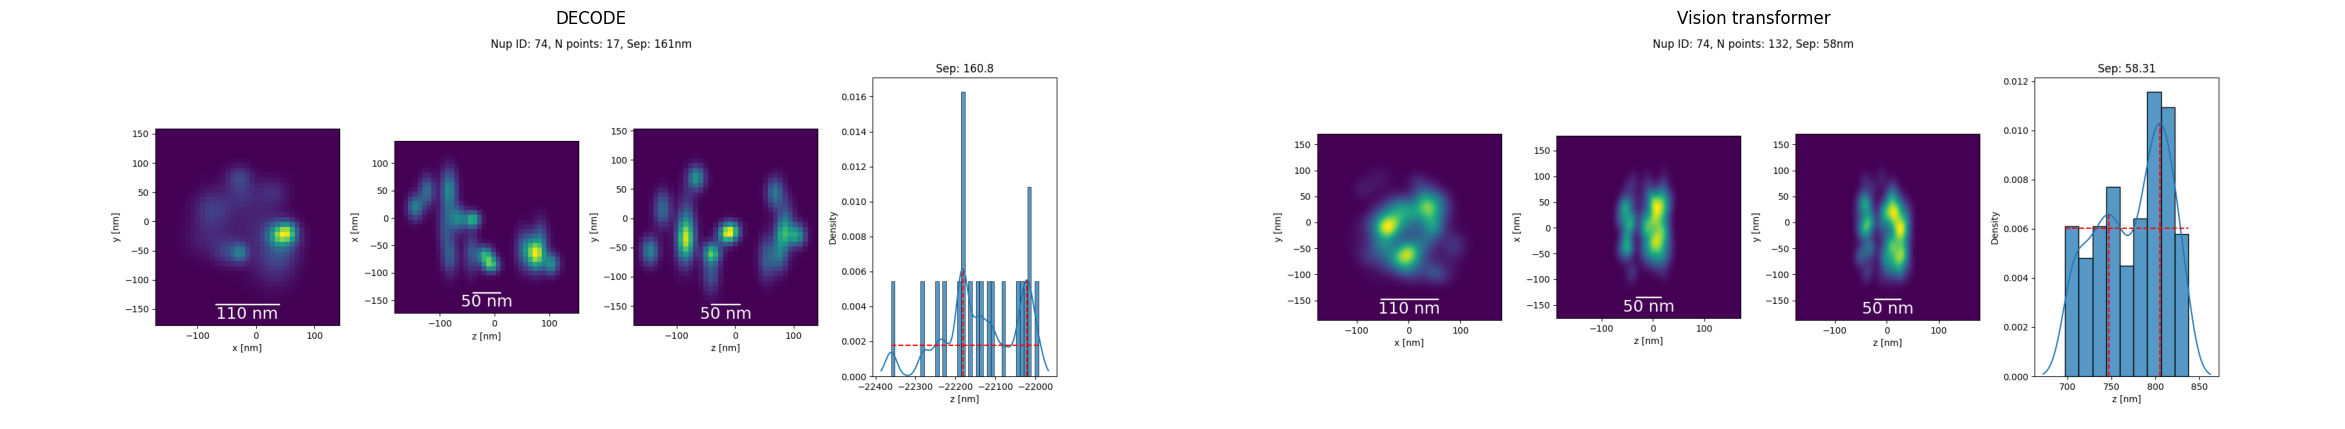

nup_84_gaussian.png


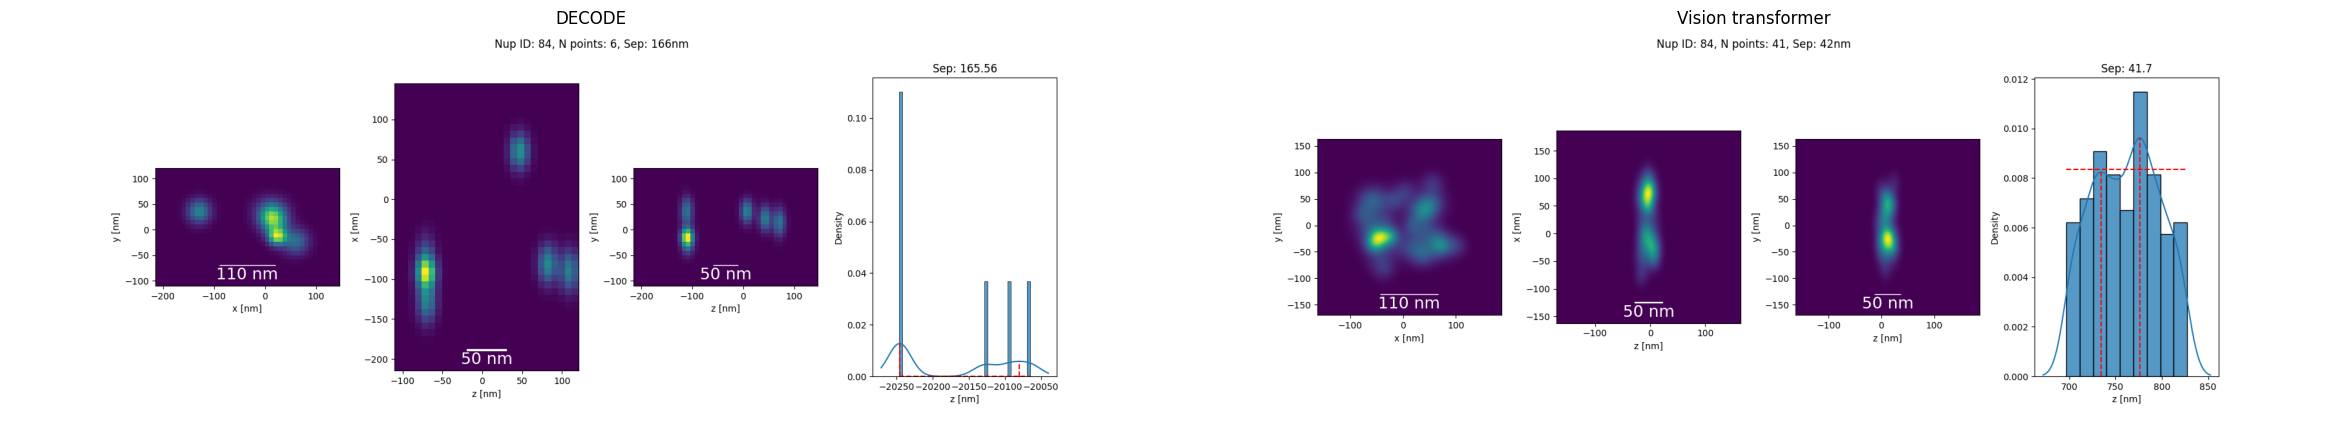

nup_86_gaussian.png


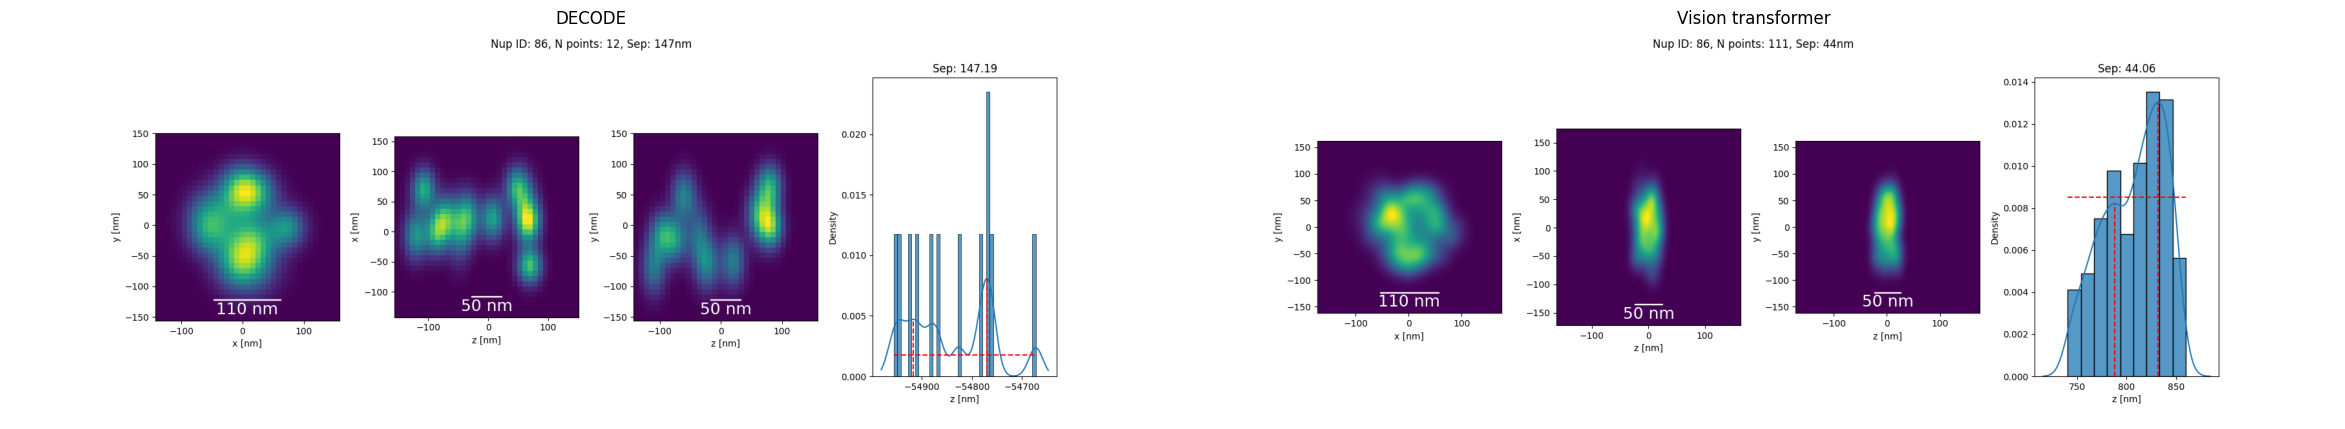

nup_88_gaussian.png


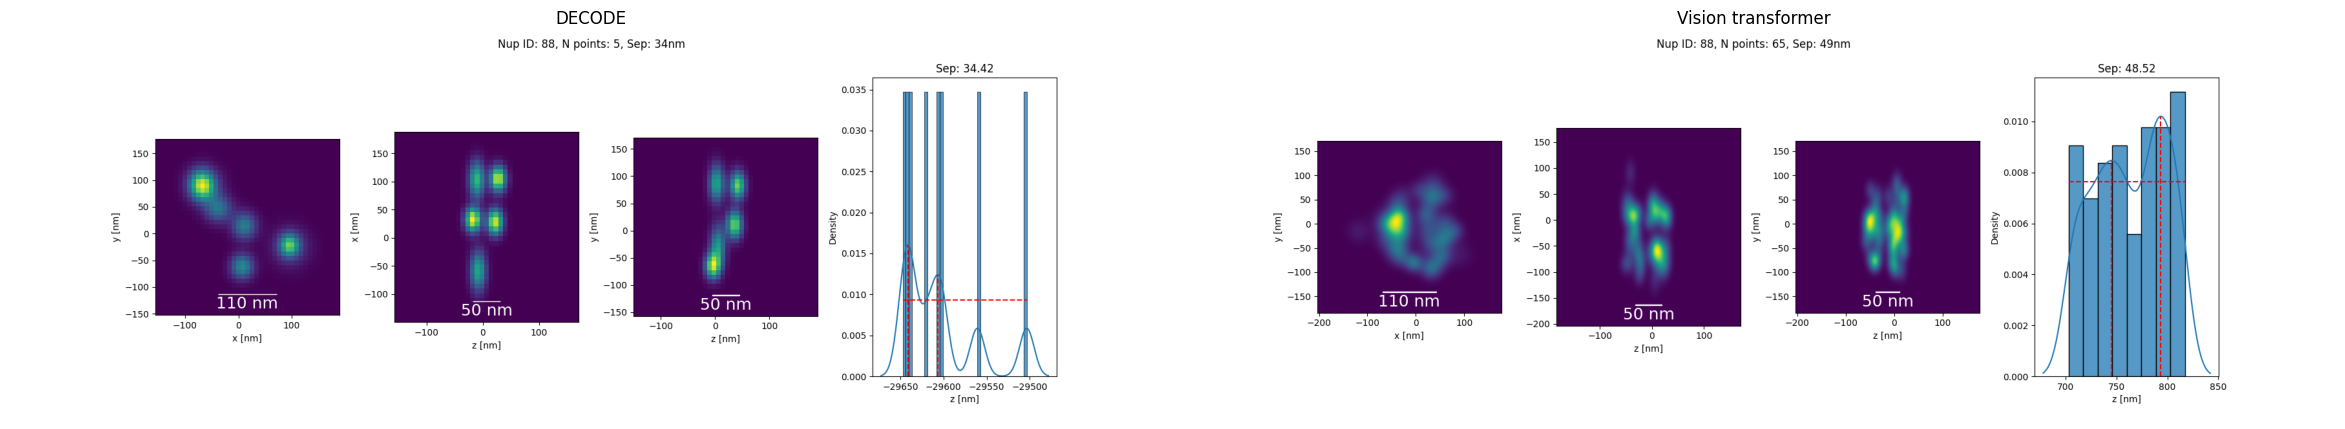

nup_97_gaussian.png


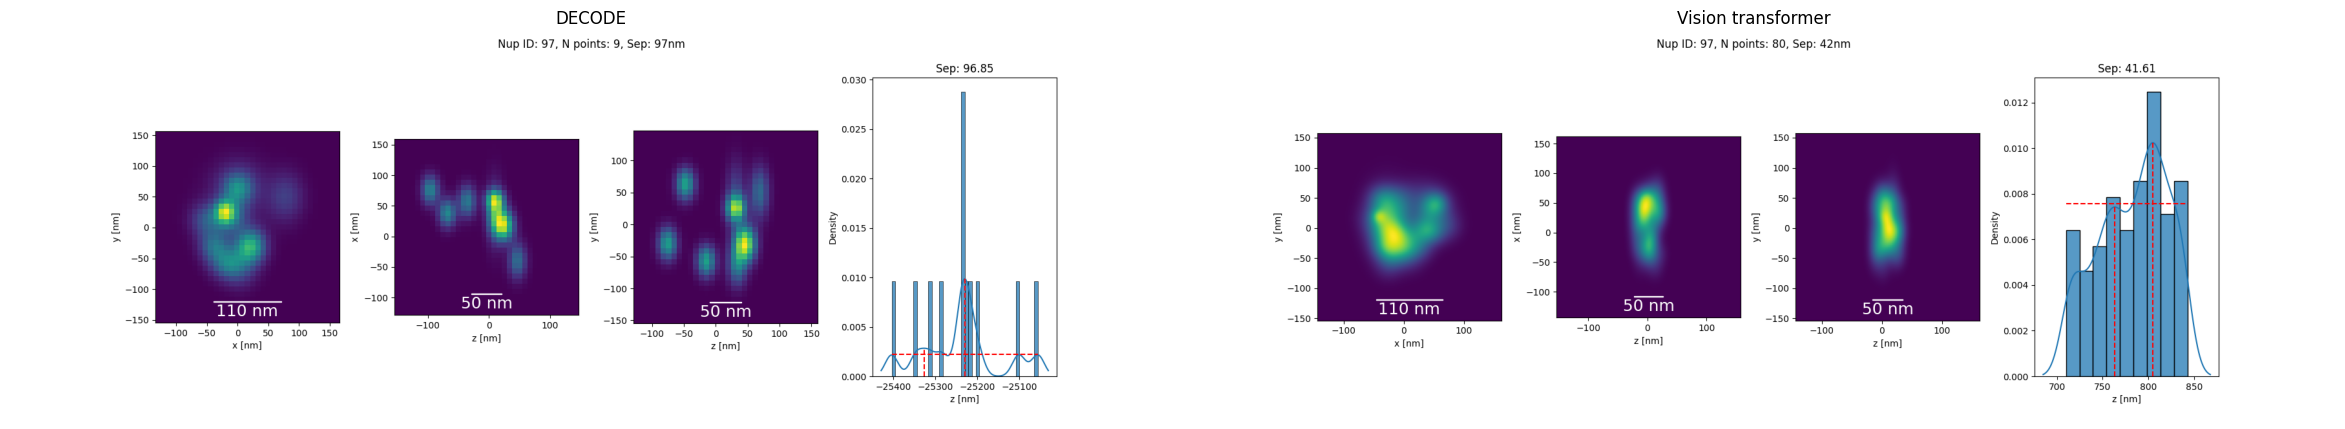

nup_100_gaussian.png


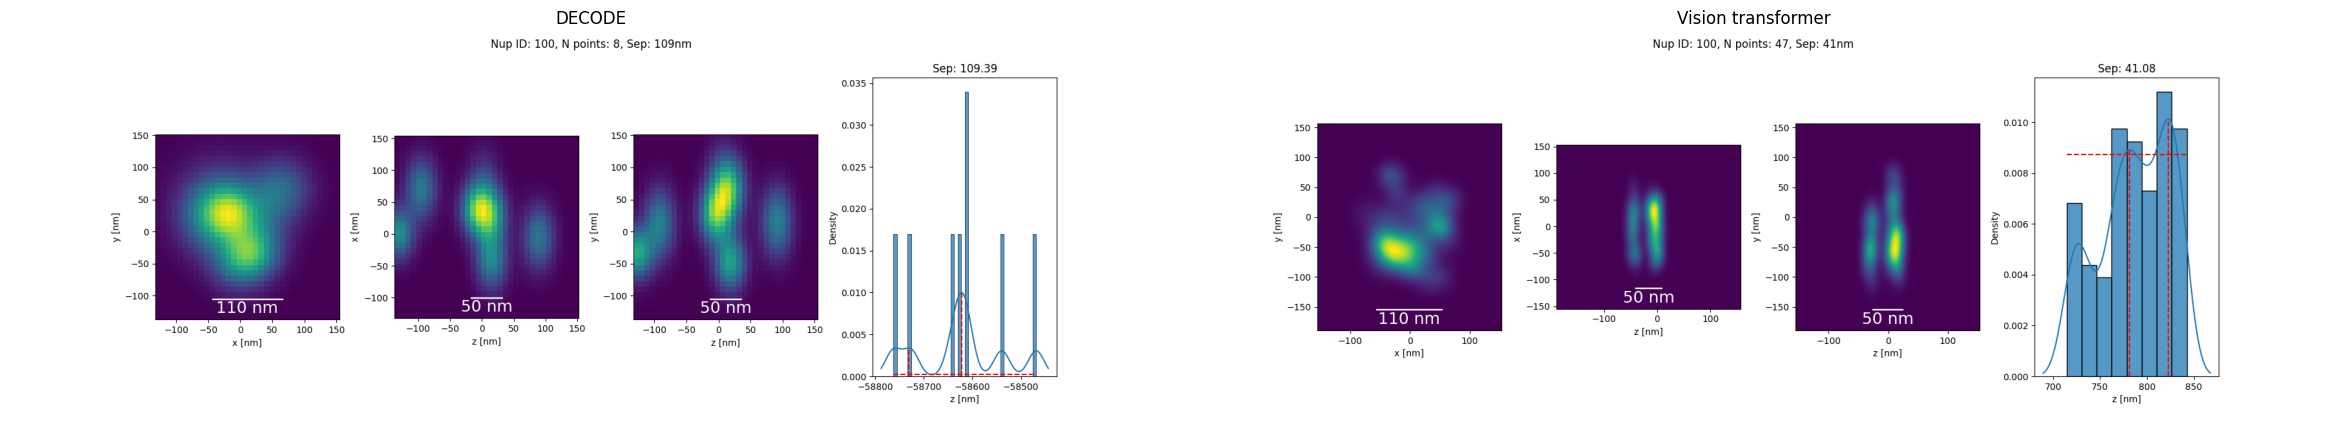

nup_105_gaussian.png


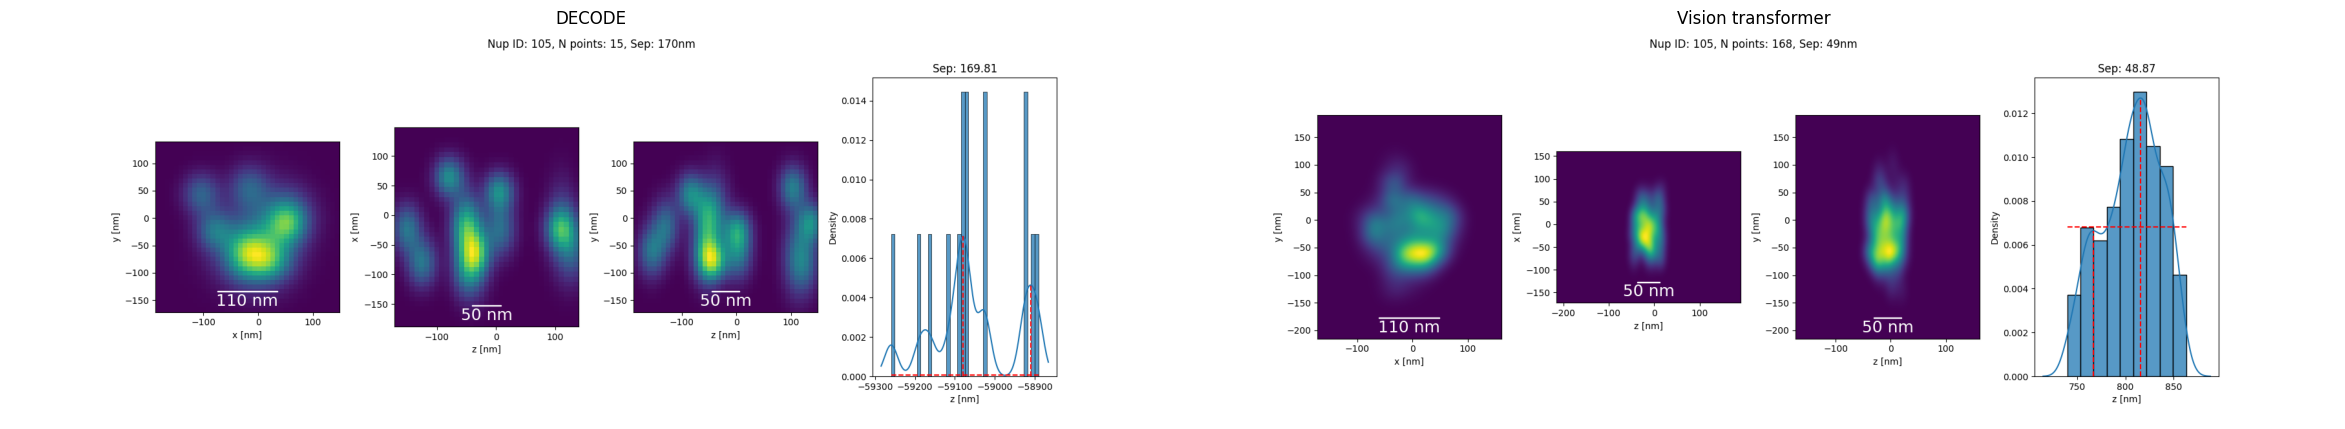

nup_107_gaussian.png


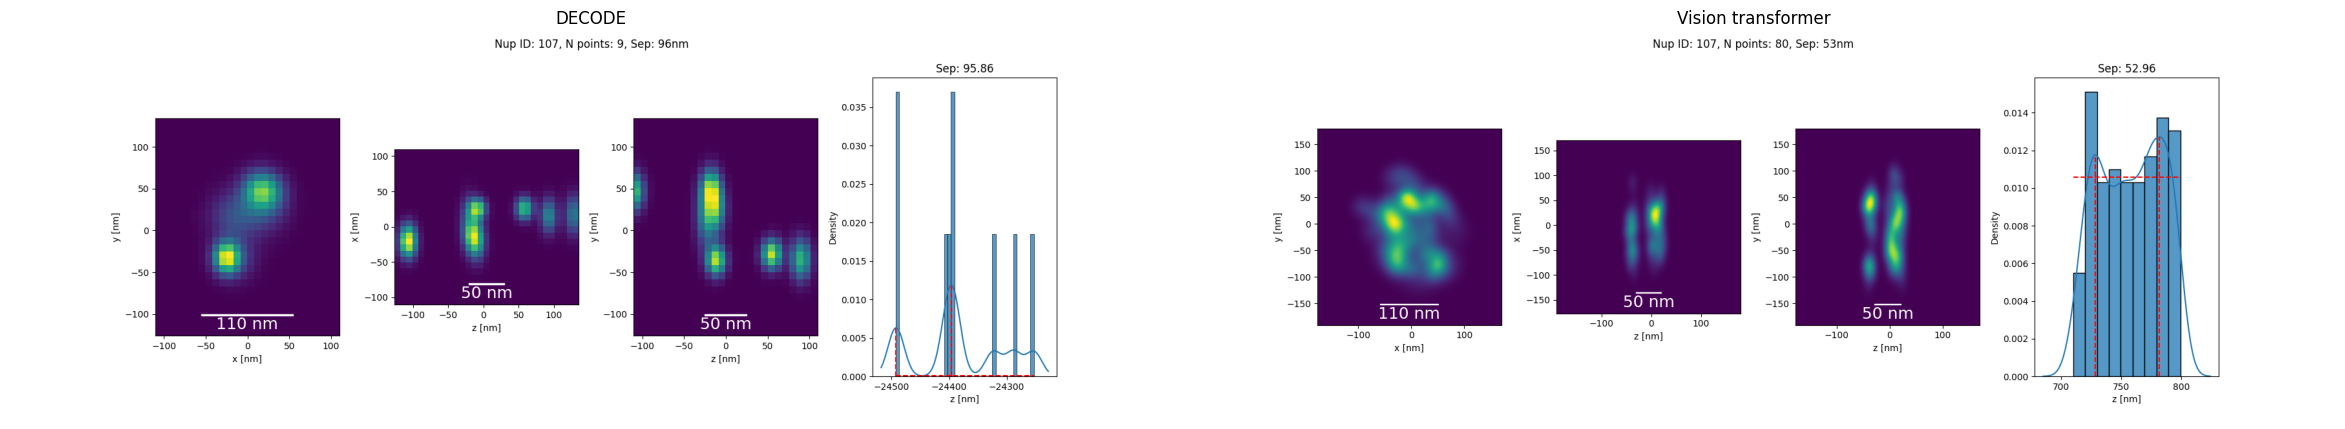

nup_109_gaussian.png


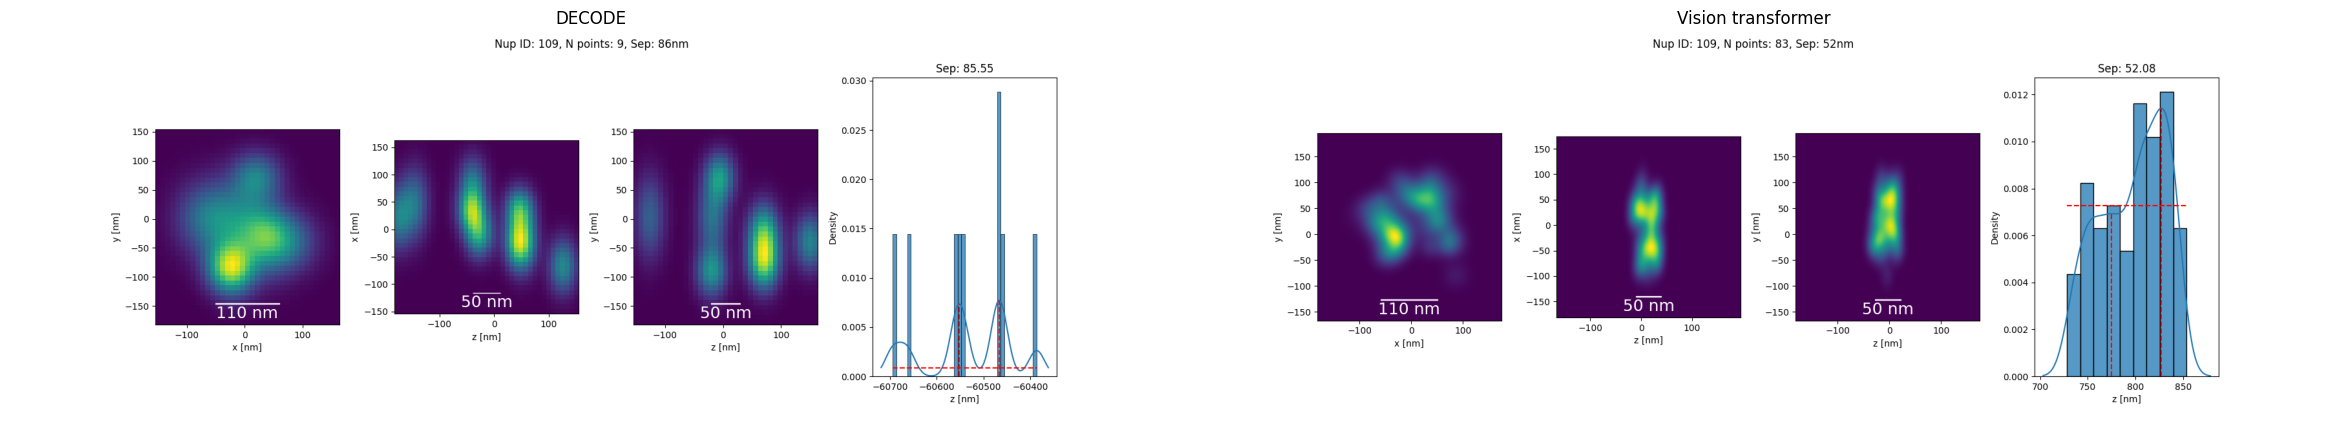

nup_110_gaussian.png


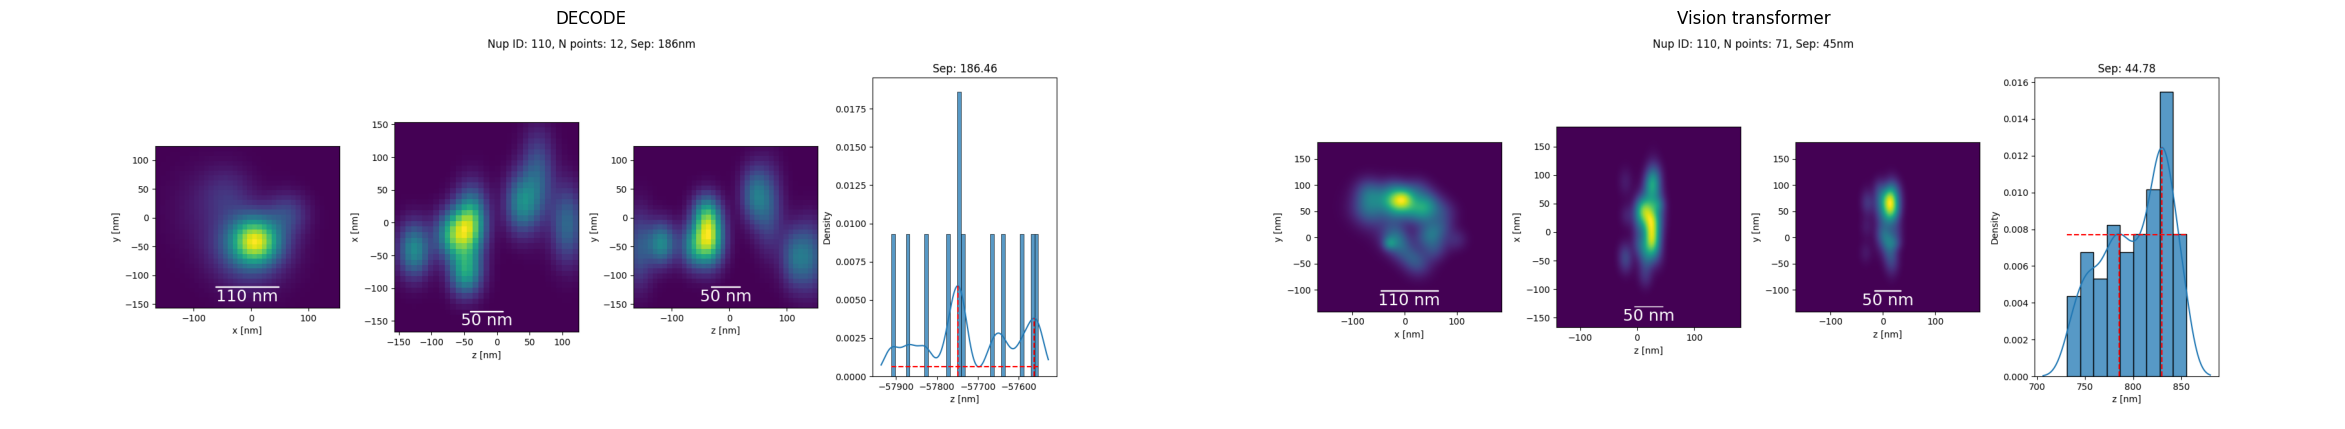

nup_114_gaussian.png


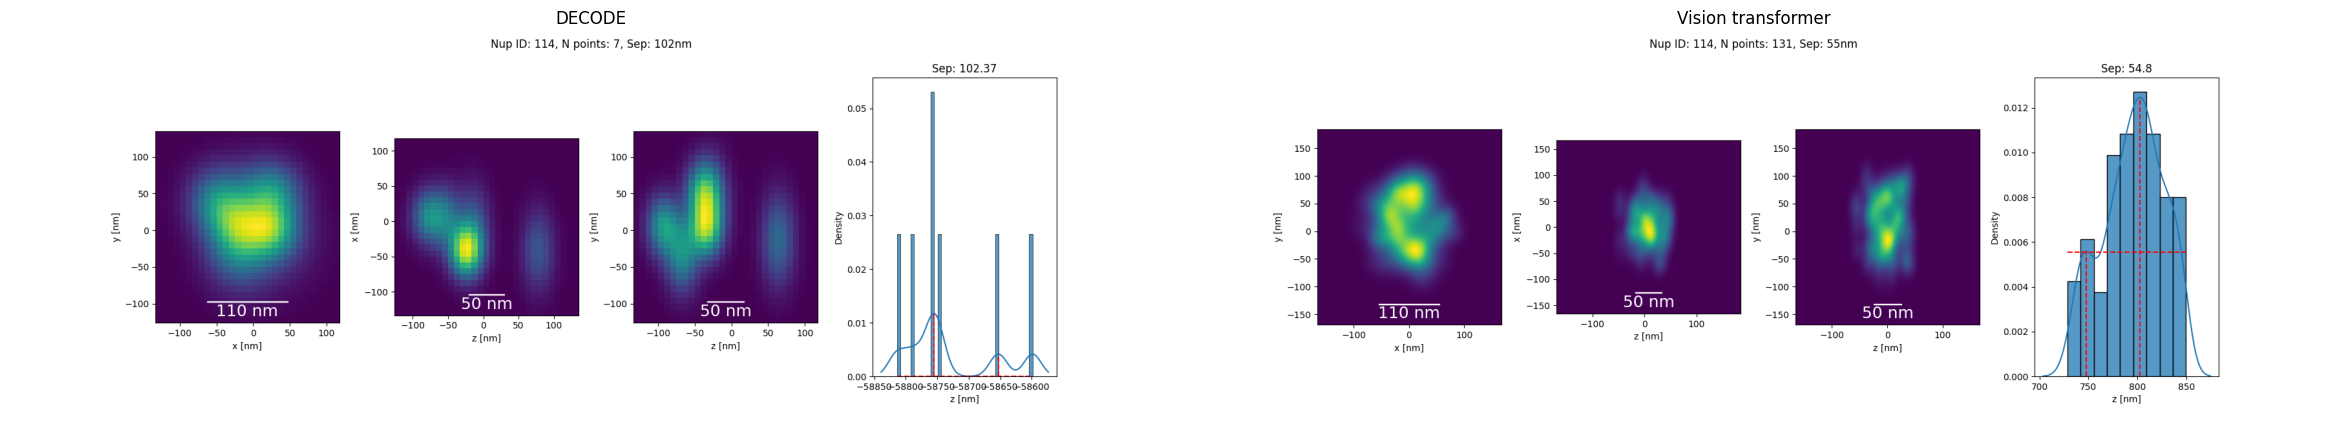

nup_116_gaussian.png


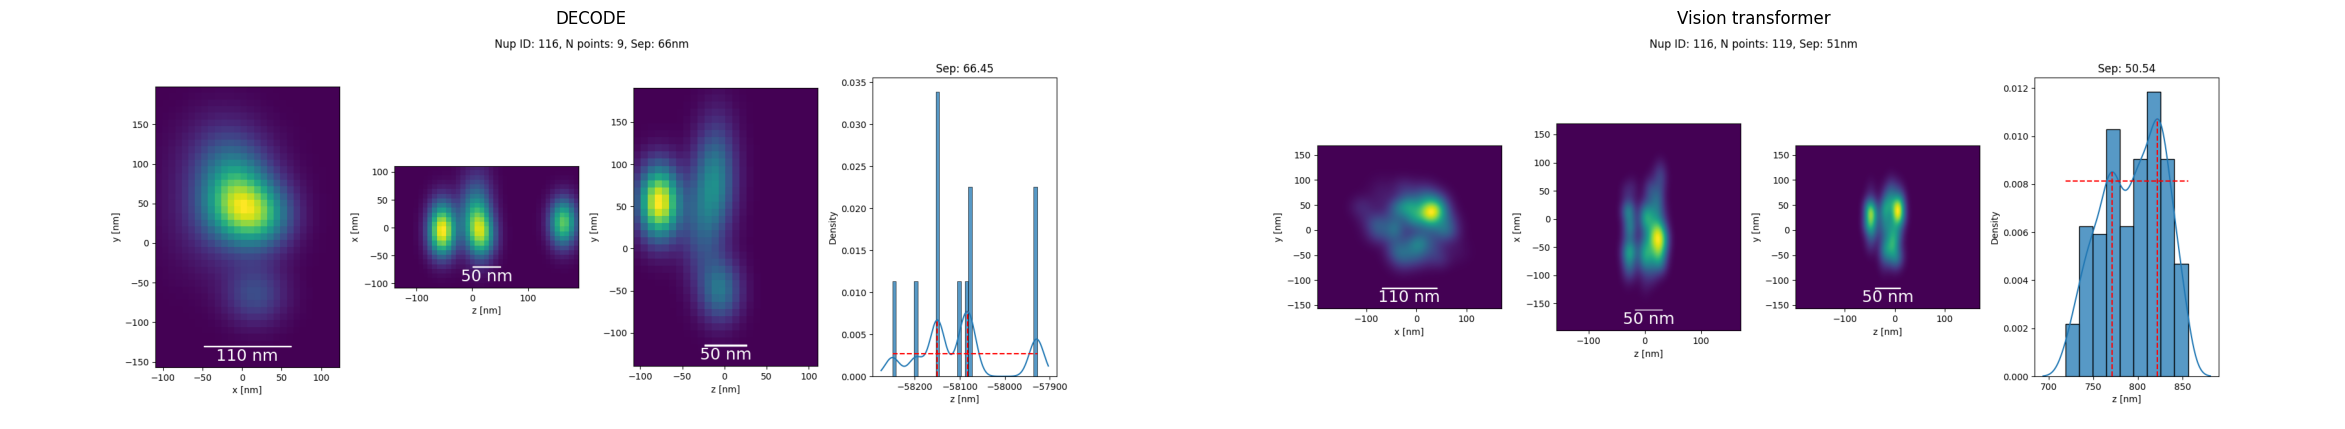

nup_119_gaussian.png


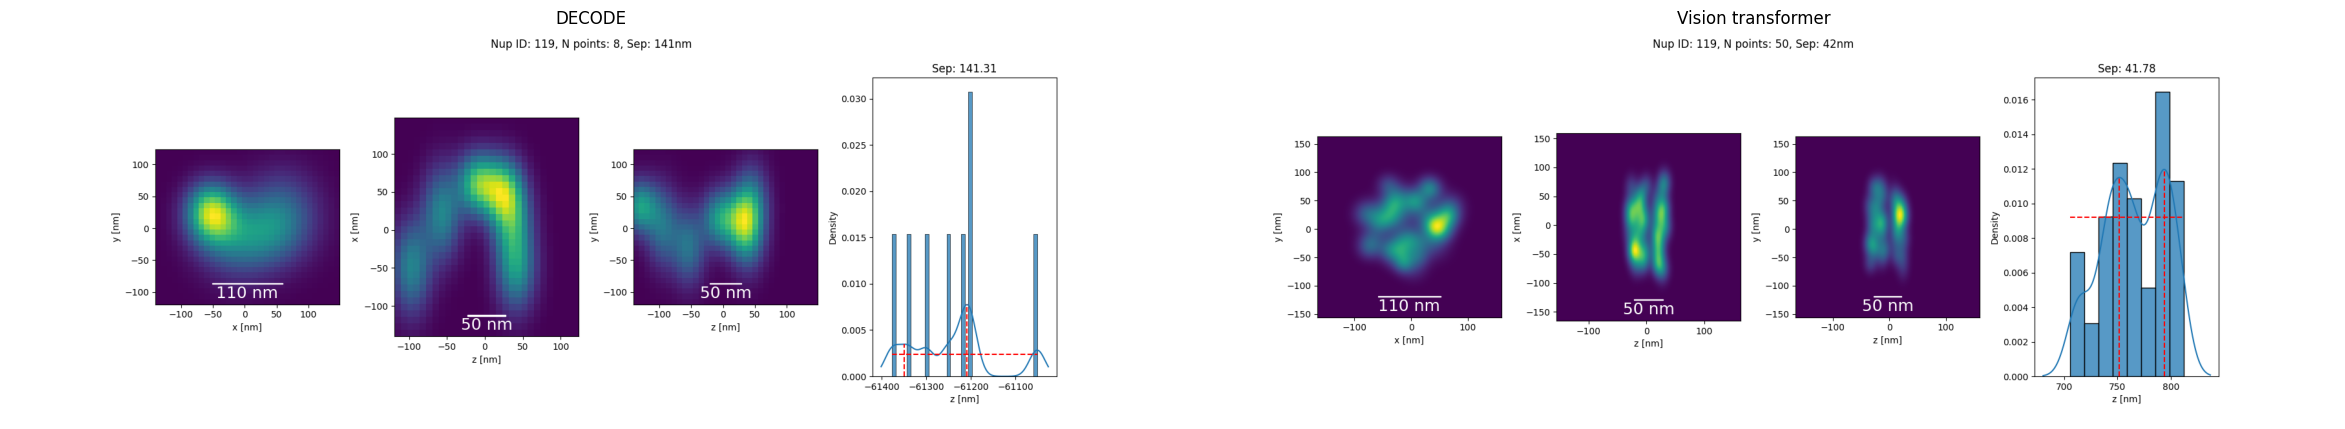

In [58]:
import matplotlib.pyplot as plt
import os
import glob
from natsort import natsorted
import matplotlib.image as mpimg

dir1 = '/home/miguel/Projects/smlm_z/publication/comparisons/decode_2/notebooks/nup_renders3/*/'
dir2 = '/home/miguel/Projects/smlm_z/publication/VIT_openframe/out*/out_nup/nup_renders3/*/'

imgs = [set(list(map(os.path.basename, glob.glob(f'{dirname}/*.png')))) for dirname in (dir1, dir2)]
imnames = imgs[0].intersection(imgs[1])
print(len(imnames))

for imname in natsorted(imnames):
    impath = glob.glob(dir1+imname)[0]
    img1 = mpimg.imread(impath)

    impath2 = glob.glob(dir2+imname)[0]
    if 'good' not in impath2:
        continue
    print(imname)

    img2 = mpimg.imread(impath2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
    # Display the first image
    ax1.imshow(img1)
    ax1.set_title('DECODE')
    ax1.axis('off')
    
    # Display the second image
    ax2.imshow(img2)
    ax2.set_title('Vision transformer')
    ax2.axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0)
    
    # Display the figure
    plt.show()
        
        